# Quantitative Trading Strategies
# Financial Ratio Quantile Strategies

## FINM 33150 - 2024

* Baptiste PEPIN

### Import modules

In [1]:
import os
import warnings
from datetime import datetime, timedelta

import numpy as np
import optuna
import pandas as pd
import quandl
import seaborn as sns
from matplotlib import pyplot as plt

import config

warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

### 1. Introduction

We will first retrieve the data from Quandl and transform it for our purpose. We will then implement the strategy before trying to explore some of its parameters. Finally, we will analyze the results of our strategy with different sets of parameters.

The complex part of this homework was to pre-process and clean the data to make it usable for our strategy. This step starts by getting the data through the Quandl API and then selecting the tickers that satisfy some predefined conditions. Then, we had to join the different tables and align the informations on their respective dates when they are being reported. After and only after this step, we were able to compute the ratios we wanted to use in our strategy and to validate our results with a given example.

The second part of that problem will be to implement a quantile-based trading strategy. We will use the different ratios computed to divide the securities into quantiles and then buy the securities in the highest quantile and sell the securities in the lowest quantile. To see how our strategy is performing with the different ratios, we will try to explore some of its parameters before finally analyzing the results.

### 2. Data Manipulation

#### 2.1. Data Collection

We will start by retrieving the data from Quandl. We will use the Quandl Python package to do so. To perform this extraction, one need to get access to the NASDAQ API key and to set it in the code below.

The `fetch_quandl_table` function will download the data and save it in a local folder. If the data has already been downloaded, it will not be downloaded again. Instead, the function will return the path to the local file containing the data.

In [2]:
def grab_quandl_table(
        table_path,
        avoid_download=False,
        replace_existing=False,
        date_override=None,
        allow_old_file=False,
        **kwargs,
):
    root_data_dir = os.path.join(os.getcwd(), "quandl_data_table_downloads")
    data_symlink = os.path.join(root_data_dir, f"{table_path}_latest.zip")
    if avoid_download and os.path.exists(data_symlink):
        print(f"Skipping any possible download of {table_path}")
        return data_symlink

    table_dir = os.path.dirname(data_symlink)
    if not os.path.isdir(table_dir):
        print(f'Creating new data dir {table_dir}')
        os.mkdir(table_dir)

    if date_override is None:
        my_date = datetime.datetime.now().strftime("%Y%m%d")
    else:
        my_date = date_override
    data_file = os.path.join(root_data_dir, f"{table_path}_{my_date}.zip")

    if os.path.exists(data_file):
        file_size = os.stat(data_file).st_size
        if replace_existing or not file_size > 0:
            print(f"Removing old file {data_file} size {file_size}")
        else:
            print(
                f"Data file {data_file} size {file_size} exists already, no need to download"
            )
            return data_file

    dl = quandl.export_table(
        table_path, filename=data_file, api_key=config.QUANDL_API_KEY, **kwargs
    )
    file_size = os.stat(data_file).st_size
    if os.path.exists(data_file) and file_size > 0:
        print(f"Download finished: {file_size} bytes")
        if not date_override:
            if os.path.exists(data_symlink):
                print(f"Removing old symlink")
                os.unlink(data_symlink)
            print(f"Creating symlink: {data_file} -> {data_symlink}")
            os.symlink(
                data_file, data_symlink,
            )
    else:
        print(f"Data file {data_file} failed download")
        return
    return data_symlink if (date_override is None or allow_old_file) else "NoFileAvailable"


def fetch_quandl_table(table_path, avoid_download=True, **kwargs):
    return pd.read_csv(
        grab_quandl_table(table_path, avoid_download=avoid_download, **kwargs), low_memory=False
    )

In [3]:
# FUNDAMENTALS CONDENSED (ZACKS/FC)

zfc = fetch_quandl_table('ZACKS/FC')
zfc['per_end_date'] = pd.to_datetime(zfc['per_end_date'])
zfc['filing_date'] = pd.to_datetime(zfc['filing_date'])
zfc.head()

Skipping any possible download of ZACKS/FC


,m_ticker,ticker,comp_name,comp_name_2,exchange,currency_code,per_end_date,per_type,per_code,per_fisc_year,...,stock_based_compsn_qd,cash_flow_oper_activity_qd,net_change_prop_plant_equip_qd,comm_stock_div_paid_qd,pref_stock_div_paid_qd,tot_comm_pref_stock_div_qd,wavg_shares_out,wavg_shares_out_diluted,eps_basic_net,eps_diluted_net
0,CPG,3262Q,NaN,CMS ENERGY -G,NaN,USD,2006-12-31,A,NaN,2006,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CPG,3262Q,NaN,CMS ENERGY -G,NaN,USD,2007-12-31,A,NaN,2007,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CPG,3262Q,NaN,CMS ENERGY -G,NaN,USD,2008-12-31,A,NaN,2008,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,CPG,3262Q,NaN,CMS ENERGY -G,NaN,USD,2009-12-31,A,NaN,2009,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CPG,3262Q,NaN,CMS ENERGY -G,NaN,USD,2010-12-31,A,NaN,2010,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# FUNDAMENTALS RATIOS (ZACKS/FR)

zfr = fetch_quandl_table('ZACKS/FR')
zfr['per_end_date'] = pd.to_datetime(zfr['per_end_date'])
zfr.head()

Skipping any possible download of ZACKS/FR


,m_ticker,ticker,comp_name,comp_name_2,exchange,currency_code,per_end_date,per_type,per_code,per_fisc_year,...,invty_turn,rcv_turn,day_sale_rcv,ret_equity,ret_tang_equity,ret_asset,ret_invst,free_cash_flow_per_share,book_val_per_share,oper_cash_flow_per_share
0,CPG,3262Q,NaN,CMS ENERGY -G,NaN,USD,2006-12-31,A,NaN,2006,...,NaN,NaN,NaN,2.4085,1.3277,0.7184,2.3844,NaN,NaN,NaN
1,CPG,3262Q,NaN,CMS ENERGY -G,NaN,USD,2007-12-31,A,NaN,2007,...,NaN,NaN,NaN,-0.2536,-0.1624,-0.0851,-0.2411,NaN,NaN,NaN
2,CPG,3262Q,NaN,CMS ENERGY -G,NaN,USD,2008-12-31,A,NaN,2008,...,NaN,NaN,NaN,-0.1566,-0.0905,-0.0507,-0.1497,NaN,NaN,NaN
3,CPG,3262Q,NaN,CMS ENERGY -G,NaN,USD,2009-12-31,A,NaN,2009,...,NaN,NaN,NaN,-0.2429,-0.1426,-0.0778,-0.2328,NaN,NaN,NaN
4,CPG,3262Q,NaN,CMS ENERGY -G,NaN,USD,2010-12-31,A,NaN,2010,...,NaN,NaN,NaN,-0.0653,-0.0375,-0.0209,-0.0627,NaN,NaN,NaN


In [5]:
# MASTER TABLE (ZACKS/MT)

zmt = fetch_quandl_table('ZACKS/MT')
zmt.head()

Skipping any possible download of ZACKS/MT


,m_ticker,ticker,comp_name,comp_name_2,exchange,currency_code,ticker_type,active_ticker_flag,comp_url,sic_4_code,...,per_end_month_nbr,mr_split_date,mr_split_factor,comp_cik,country_code,country_name,comp_type,optionable_flag,sp500_member_flag,asset_type
0,Z86Z,0425B,NaN,PCA INTL,NaN,NaN,NaN,N,NaN,NaN,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,FFFC,1186Q,NaN,FRANKLIN FIRST,NaN,NaN,NaN,N,NaN,NaN,...,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,WSTF,1197Q,NaN,WESTERN FINL CP,NaN,NaN,NaN,N,NaN,NaN,...,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,HBCI,1209Q,NaN,HARMONIA,NaN,NaN,NaN,N,NaN,NaN,...,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,TONE,1352Q,NaN,ONE BCP,NaN,NaN,NaN,N,NaN,NaN,...,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# MARKET VALUE SUPPLEMENT (ZACKS/MKTV)

zmktv = fetch_quandl_table('ZACKS/MKTV')
zmktv['per_end_date'] = pd.to_datetime(zmktv['per_end_date'])
zmktv.head()

Skipping any possible download of ZACKS/MKTV


,ticker,m_ticker,comp_name,fye,per_type,per_end_date,active_ticker_flag,mkt_val,ep_val
0,A,A2,AGILENT TECH,10,Q,2023-09-30,Y,32717.11,34122.11
1,A,A2,AGILENT TECH,10,Q,2023-06-30,Y,35518.94,37076.94
2,A,A2,AGILENT TECH,10,Q,2023-03-31,Y,40907.39,42390.39
3,A,A2,AGILENT TECH,10,Q,2022-12-31,Y,44275.46,45955.46
4,A,A2,AGILENT TECH,10,Q,2022-09-30,Y,35983.73,37638.73


In [7]:
# SHARES OUT SUPPLEMENT (ZACKS/SHRS)

zshrs = fetch_quandl_table('ZACKS/SHRS')
zshrs['per_end_date'] = pd.to_datetime(zshrs['per_end_date'])
zshrs.head()

Skipping any possible download of ZACKS/SHRS


,ticker,m_ticker,comp_name,fye,per_type,per_end_date,active_ticker_flag,shares_out,avg_d_shares
0,A,A2,AGILENT TECH,10,Q,2023-07-31,Y,292.59,295.0
1,A,A2,AGILENT TECH,10,Q,2023-04-30,Y,295.38,297.0
2,A,A2,AGILENT TECH,10,Q,2023-01-31,Y,295.70,297.0
3,A,A2,AGILENT TECH,10,Q,2022-10-31,Y,296.04,298.0
4,A,A2,AGILENT TECH,10,Q,2022-07-31,Y,296.04,299.0


In [8]:
# PRICES (QUOTEMEDIA/PRICES)

prices = fetch_quandl_table('QUOTEMEDIA/PRICES')
prices['date'] = pd.to_datetime(prices['date'])
prices.head()

Skipping any possible download of QUOTEMEDIA/PRICES


,ticker,date,open,high,low,close,volume,dividend,split,adj_open,adj_high,adj_low,adj_close,adj_volume
0,JTKWY,2022-03-11,6.1700,7.3200,5.790,6.72,9440097.0,0.0,1.0,6.1700,7.3200,5.790,6.72,9440097.0
1,JTKWY,2022-03-10,6.1600,6.1750,5.935,6.07,2261623.0,0.0,1.0,6.1600,6.1750,5.935,6.07,2261623.0
2,FG_1,2020-06-01,8.1000,8.3900,8.100,8.39,3086317.0,0.0,1.0,8.1000,8.3900,8.100,8.39,3086317.0
3,FLWS,2022-03-09,14.5700,14.9588,14.410,14.45,662492.0,0.0,1.0,14.5700,14.9588,14.410,14.45,662492.0
4,RENW_,2020-01-29,21.9768,21.9900,21.970,21.99,319.0,0.0,1.0,21.9768,21.9900,21.970,21.99,319.0


#### 2.2. Sample data - SEC Reports

To better understand the data and to perform a first exploration of the different variables available, we will try to reproduce the SEC Report for Eli Lilly provided in the homework.

In [9]:
def get_sec_reports(fc, fr, mktv, shrs, start_date, end_date, ticker):
    report = fc[fc['ticker'] == ticker][
        ['ticker', 'per_end_date', 'filing_date', 'tot_revnu', 'eps_diluted_net', 'basic_net_eps', 'tot_lterm_debt',
         'net_lterm_debt', 'net_curr_debt', 'zacks_sector_code', 'zacks_x_ind_code', 'zacks_metrics_ind_code',
         'per_type']]

    report = report.merge(
        fr[fr['ticker'] == ticker][['tot_debt_tot_equity', 'ret_invst', 'free_cash_flow_per_share', 'per_end_date']],
        on='per_end_date', how='left')

    report = report.merge(mktv[mktv['ticker'] == ticker][['mkt_val', 'per_end_date']], on='per_end_date', how='left')

    report = report.merge(shrs[shrs['ticker'] == ticker][['shares_out', 'per_end_date']], on='per_end_date', how='left')

    report['debt_to_eq'] = report[['tot_debt_tot_equity']]
    report['earn_per_sh'] = report[['basic_net_eps']]
    report['long_term_debt'] = report[['net_lterm_debt']]

    report = report.groupby(['per_end_date']).max().T.loc[
             ('filing_date', 'tot_revnu', 'eps_diluted_net', 'basic_net_eps',
              'tot_lterm_debt', 'net_lterm_debt', 'net_curr_debt',
              'zacks_x_ind_code', 'zacks_sector_code', 'zacks_metrics_ind_code',
              'tot_debt_tot_equity', 'ret_invst', 'free_cash_flow_per_share',
              'shares_out', 'per_type', 'mkt_val', 'debt_to_eq', 'earn_per_sh',
              'long_term_debt'), start_date:end_date]

    return report

In [10]:
get_sec_reports(zfc, zfr, zmktv, zshrs, '2022-06-30', '2023-09-30', 'LLY')

per_end_date,2022-06-30,2022-09-30,2022-12-31,2023-03-31,2023-06-30,2023-09-30
filing_date,2022-08-04 00:00:00,2022-11-01 00:00:00,2023-02-22 00:00:00,2023-04-27 00:00:00,2023-08-08 00:00:00,2023-11-02 00:00:00
tot_revnu,6488.0,6941.6,28541.4,6960.0,8312.1,9498.6
eps_diluted_net,1.05,1.61,6.9,1.49,1.95,-0.06
basic_net_eps,1.05,1.61,6.9,1.49,1.95,-0.06
tot_lterm_debt,14692.0,14143.8,14737.5,18880.5,18158.4,17923.6
net_lterm_debt,-1560.0,-1560.0,-1560.0,3958.5,3958.5,3958.5
net_curr_debt,2117.2,1741.3,1498.0,-1498.0,-1498.0,97.0
zacks_x_ind_code,225.0,225.0,225.0,225.0,225.0,225.0
zacks_sector_code,4.0,4.0,4.0,4.0,4.0,4.0
zacks_metrics_ind_code,13.0,13.0,13.0,13.0,13.0,13.0


We can verify with this table that we get the same result as 6.0.1 in the homework: SEC Reports for recent sample data for Eli Lilly (ticker LLY). In a later section, we will perform different operations on our data to have this report available directly, along with some new ratios.

#### 2.3. Tickers selection

We are now going to select the tickers of US Equities that satisfy the following conditions:
- End-of-day adjusted closing prices available
- Debt/market cap ratio is greater than 0.1 somewhere
- Not in the automobile, financial or insurance sector

and those conditions should be satisfied for the entire period of interest.

In [11]:
# Parameters

start_data = pd.to_datetime('2015-01-01')
end_data = pd.to_datetime('2024-01-01')

start_date = pd.to_datetime('2016-01-01')
end_date = pd.to_datetime('2023-06-30')

tickers_available = pd.read_csv('https://static.quandl.com/zacks/zacks-tickers.csv', header=None)
tickers_available.rename(columns={0: 'ticker', 1: 'name'}, inplace=True)
tickers_available.head()

,ticker,name
0,3262Q,CMS ENERGY -G
1,A,AGILENT TECH
2,AA,ALCOA INC
3,AAAP,ADV ACCELERATOR
4,AAC,AAC HOLDINGS


In [12]:
# Select tickers of US equities

us_eq_tickers = zmt[(zmt['country_code'] == 'US') & \
                    (zmt['ticker'].isin(tickers_available['ticker'])) & \
                    (zmt['asset_type'] == 'COM') & \
                    (zmt['zacks_x_sector_desc'] != 'nan')
                    ]['ticker'].to_frame('ticker')

In [13]:
def filter_on_tickers(df, tickers):
    return df[df['ticker'].isin(tickers)]

In [14]:
# Filter data on tickers

prices = filter_on_tickers(prices, us_eq_tickers['ticker'])
prices = prices[(prices['date'] >= start_data) & (prices['date'] <= end_data)]

zfc = filter_on_tickers(zfc, us_eq_tickers['ticker'])
zfc = zfc[(zfc['per_end_date'] >= start_data) & (zfc['per_end_date'] <= end_data)]
zfc = zfc[zfc['per_type'] == 'Q']

zfr = filter_on_tickers(zfr, us_eq_tickers['ticker'])
zfr = zfr[(zfr['per_end_date'] >= start_data) & (zfr['per_end_date'] <= end_data)]
zfr = zfr[(zfr['per_type'] == 'Q')]

zmt = filter_on_tickers(zmt, us_eq_tickers['ticker'])

zmktv = filter_on_tickers(zmktv, us_eq_tickers['ticker'])
zmktv = zmktv[(zmktv['per_end_date'] >= start_data) & (zmktv['per_end_date'] <= end_data)]

zshrs = filter_on_tickers(zshrs, us_eq_tickers['ticker'])
zshrs = zshrs[(zshrs['per_end_date'] >= start_data) & (zshrs['per_end_date'] <= end_data)]

We filter to keep only the quarterly data because we do not want to use the annual one in case the quarterly is not available. This is because Zacks apparently does not do the usual post-processing. The reported data is not annualized, therefore, using annual data along with our quarterly data would not be consistent.

##### 2.3.1. End-of-day adjusted closing prices condition

We want to select the tickers that have a full set of end-of-day adjusted closing prices for the period of interest.

In [15]:
def select_tickers_with_full_adj_close(df, start_date, end_date):
    filtered_df = df[(df['date'] >= start_date) & (df['date'] <= end_date)]

    unique_tickers = filtered_df.groupby('ticker').filter(lambda x: x['adj_close'].notnull().all())['ticker'].unique()

    return unique_tickers

In [16]:
tickers_end_of_day_adj_close = select_tickers_with_full_adj_close(prices, start_date, end_date)

print(f'Number of tickers without missing end-of-day adjusted closing prices: {len(tickers_end_of_day_adj_close)}')

Number of tickers without missing end-of-day adjusted closing prices: 2581


##### 2.3.2. Debt/market cap ratio condition

This second filter will select the tickers that have a debt/market cap ratio greater than 0.1 somewhere in the period of interest.

In [17]:
def get_tickers_debt_market_cap_ratio(df, start_date, end_date, threshold=0.1):
    filtered_df = df[(df['per_end_date'] >= start_date) & (df['per_end_date'] <= end_date)]

    unique_tickers = filtered_df.groupby('ticker').filter(lambda x: (x['tot_debt_tot_equity']).max() > threshold)[
        'ticker'].unique()

    return unique_tickers

In [18]:
tickers_debt_market_cap_ratio = get_tickers_debt_market_cap_ratio(zfr, start_date, end_date, 0.1)

print(f'Number of tickers with debt/market cap ratio > 0.1: {len(tickers_debt_market_cap_ratio)}')

Number of tickers with debt/market cap ratio > 0.1: 2473


##### 2.3.3. Industry sector condition

Now we want to exclude the tickers that are in the automobile, financial or insurance sector. To do so, we refer to the Zacks Sector Industry Mapping Scheme in order to identify the sector codes to exclude.

In [19]:
def exclude_tickers_from_industry_sector(df, x_sector_code, x_ind_code):
    filtered_df = df[~df['zacks_x_sector_code'].isin(x_sector_code)]
    filtered_df = filtered_df[~filtered_df['zacks_x_ind_code'].isin(x_ind_code)]

    unique_tickers = filtered_df['ticker'].unique()

    return unique_tickers

In [20]:
x_sector_code = [5, 13]
x_ind_code = []

tickers_exclude_industry_sector = exclude_tickers_from_industry_sector(zmt, x_sector_code, x_ind_code)

print(f'Number of tickers not in the automobile, financial or insurance sector: {len(tickers_exclude_industry_sector)}')

Number of tickers not in the automobile, financial or insurance sector: 2421


##### 2.3.4. Intersection of the conditions

We can now take the intersection of the tickers that satisfy the three conditions above.

In [21]:
tickers_intersection = list(
    set(tickers_end_of_day_adj_close).intersection(set(tickers_debt_market_cap_ratio)).intersection(
        set(tickers_exclude_industry_sector)))
tickers_intersection.sort()

tickers = pd.DataFrame(tickers_intersection, columns=['ticker'])

print(f'Number of tickers that satisfy all the conditions: {len(tickers_intersection)}')

Number of tickers that satisfy all the conditions: 1627


In [22]:
# Filter data on tickers

prices = filter_on_tickers(prices, tickers['ticker'])
zfc = filter_on_tickers(zfc, tickers['ticker'])
zfr = filter_on_tickers(zfr, tickers['ticker'])
zmt = filter_on_tickers(zmt, tickers['ticker'])
zmktv = filter_on_tickers(zmktv, tickers['ticker'])
zshrs = filter_on_tickers(zshrs, tickers['ticker'])

As we said, for now, we will only consider the data for the tickers selected above. They all verify the conditions we want to impose on the data. Some other conditions will apply later on. We want our tickers to have feasible calculation of the ratios we will compute now, over the entire period of interest, including for at least one per_en_date no more than one year old.

#### 2.4. Joining and aligning the data

We will start by joining the different tables together. This will allow us to make sure that we do not suffer from any bias (lookahead bias) of using some data before their actual release date. This is about managing the filing_date argument of some tables. On the filing date, the data is about to be revealed, but we only consider the information available on the following day. This means that we will switch the filing_date to the following day for the tables that have this information, before joining this table using the filing_date argument.

We decided to start with the zfc table. We will then join the other tables on the ticker and per_end_date arguments. We will also perform some pre-treatment operations on the data to make sure that we have the right information available for the ratios we want to compute, and to follow the instructions given in the homework.

In [23]:
report = zfc[
    ['ticker', 'per_end_date', 'filing_date', 'tot_revnu', 'eps_diluted_net', 'basic_net_eps', 'tot_lterm_debt',
     'net_lterm_debt', 'net_curr_debt', 'zacks_sector_code', 'zacks_x_ind_code', 'zacks_metrics_ind_code', 'per_type']]

mask = ~report['filing_date'].isnull()
report.loc[mask, 'filing_date'] += timedelta(days=1)  # The data is available on the following day

In [24]:
# Merge the different tables

report = report.merge(zfr[['ticker', 'per_end_date', 'tot_debt_tot_equity', 'ret_invst', 'free_cash_flow_per_share']],
                      on=['ticker', 'per_end_date'], how='outer')

report = report.merge(zmktv[['ticker', 'per_end_date', 'mkt_val']], on=['ticker', 'per_end_date'], how='outer')

report = report.merge(zshrs[['ticker', 'shares_out', 'per_end_date']], on=['ticker', 'per_end_date'], how='outer')

In [25]:
# Some pre-treatment operations

report['debt_to_eq'] = report[['tot_debt_tot_equity']]
report['earn_per_sh'] = report[['basic_net_eps']]
report['long_term_debt'] = report[['net_lterm_debt']]

report.loc[report['eps_diluted_net'] < 0, 'eps_diluted_net'] = 0.001  # We treat negative earnings per share as 0.001
report['net_lterm_debt'].fillna(report['tot_lterm_debt'], inplace=True)

The data we have in the zacks tables is reported quarterly (we filtered the data to only keep the quarterly data), and the dates might not correspond to a trading day for which a closing adjusted price would be available in the price table. We will therefore get the last closing-adjusted price available before the per_end_date and use it to compute the ratios we want to use in our strategy.

In [26]:
# Match the per_end_date with the date of the last closing adjusted price available before the per_end_date

date_list = prices['date'].unique().tolist()

while len(set(report['per_end_date']).difference(set(prices['date']))) > 0:
    mask = ~report['per_end_date'].isin(date_list)
    report.loc[mask, 'per_end_date'] -= pd.DateOffset(days=1)

    print('Dates with no match: ', len(set(report['per_end_date']).difference(set(prices['date']))))

Dates with no match:  17
Dates with no match:  1
Dates with no match:  0


We have now a table called report that contains all the information we need to compute the ratios, except for the prices. As a reminder, we already filtered the tickers so that they all have end-of-day adjusted closing prices available for the period of interest. We just need now to filter our report table to only keep the tickers that have the data required for the ratios we want to compute.

#### 2.5. Data Transformation - Ratios computation

Let's now transform the data to get the ratios we want to use in our strategy. This step will also allow us to apply our last filter to only keep the tickers for which the data required to compute the ratios is available. The ratios we want to compute are:
- Debt/market cap ratio
- Returns on investment
- Price/earnings ratio

and to do so, we know that as the equity price changes day-to-day, each ratio will change accordingly. Moreover, we will use the revealed data (fixed for the entire period) to compute the ratios for each period, and the market value which changes as the equity price changes.

We first select the columns we want to keep for each table, and then we merge them together so that we only have one table with all the data we need.

In [27]:
ratios = prices[['ticker', 'date', 'adj_close']].copy()
ratios['date'] = pd.to_datetime(ratios['date'])

report['date'] = pd.to_datetime(report['filing_date'])

To access the prices at the per_end_date, we will join the price table (it is our ratios dataframe) with the report table on the ticker and date arguments, along with the other columns that will be useful for us to compute the ratios. We will also fill the missing values for the closing adjusted price with the previous value.

In [28]:
# Add tot_debt_tot_equity in ratios by joining report and ratios on the filing_date

ratios = ratios.merge(report[['tot_debt_tot_equity', 'per_end_date', 'filing_date', 'ticker', 'per_type', 'date']],
                      how='outer', on=['ticker', 'date'])

ratios.sort_values(by=['ticker', 'date'], ascending=[True, True], inplace=True)

In [29]:
# Forward fill the different columns

ratios['tot_debt_tot_equity'] = ratios.sort_values(by='date', ascending=True).groupby('ticker')[
    'tot_debt_tot_equity'].ffill()

ratios['adj_close'] = ratios.sort_values(by='date', ascending=True).groupby('ticker')['adj_close'].ffill()

ratios['per_end_date'] = ratios.sort_values(by='date', ascending=True).groupby('ticker')['per_end_date'].ffill()

In [30]:
# Add the remaining useful columns from report and add prices at per_end_date

ratios = ratios.merge(prices[['ticker', 'date', 'adj_close']].ffill(), how='left', left_on=['ticker', 'per_end_date'],
                      right_on=['ticker', 'date']).set_index('ticker').rename(
    columns={'date_x': 'date', 'adj_close_x': 'adj_close', 'adj_close_y': 'adj_close_per'}).drop(['date_y'],
                                                                                                 axis=1).reset_index()

ratios = ratios.merge(report[['ticker', 'per_end_date', 'eps_diluted_net', 'basic_net_eps', 'tot_lterm_debt',
                              'net_lterm_debt', 'ret_invst', 'mkt_val']], how='left', on=['ticker', 'per_end_date'])

We now have all the data we need to compute the ratios, so we will now compute them and add them to our ratios dataframe.

- Debt/market cap ratio: $\frac{\text{Total Debt}}{\text{Total Equity}} \times \frac{\text{Equity Price at per_end_date}}{\text{Equity Price}}$
- Price/earnings ratio: $\frac{\text{Equity Price}}{\text{Earnings per Share}}$
- Returns on investment: $\frac{\text{Return on Investment} \times (\text{Market Value} + \text{Net Long-Term Debt})}{\text{Market Value} \times \frac{\text{Equity Price}}{\text{Equity Price at per_end_date}} + \text{Net Long-Term Debt}}$

In [31]:
ratios['Debt_To_Mkt_Cap'] = (ratios['tot_debt_tot_equity'] * ratios['adj_close_per']) / ratios['adj_close']

In [32]:
ratios['Price_To_Earnings'] = ratios['adj_close'] / ratios['eps_diluted_net'].fillna(ratios['basic_net_eps'])

In [33]:
ratios['Returns_On_Inv'] = (ratios['ret_invst'] * (ratios['mkt_val'] + ratios['net_lterm_debt'])) / (
        (ratios['mkt_val'] * ratios['adj_close'] / ratios['adj_close_per']) + ratios['net_lterm_debt'])

#### 2.6. Data Validation

Before starting to implement our strategy, let's check if the data we have is correct. We will start by checking the SEC Report for Eli Lilly, as we did in the first section.

##### 2.6.1. SEC Reports

In [34]:
report[(report['per_end_date'] >= '2022-06-30') & (report['per_end_date'] <= '2023-09-30') & (
        report['ticker'] == 'LLY')].groupby('per_end_date')[
    ['filing_date', 'tot_revnu', 'eps_diluted_net', 'basic_net_eps', 'tot_lterm_debt', 'net_lterm_debt',
     'net_curr_debt', 'zacks_x_ind_code', 'zacks_sector_code', 'zacks_metrics_ind_code', 'tot_debt_tot_equity',
     'ret_invst', 'free_cash_flow_per_share', 'shares_out', 'per_type', 'mkt_val', 'debt_to_eq', 'earn_per_sh',
     'long_term_debt']].first().T

per_end_date,2022-06-30,2022-09-30,2022-12-30,2023-03-31,2023-06-30,2023-09-29
filing_date,2022-08-05 00:00:00,2022-11-02 00:00:00,2023-02-23 00:00:00,2023-04-28 00:00:00,2023-08-09 00:00:00,2023-11-03 00:00:00
tot_revnu,6488.0,6941.6,7301.801,6960.0,8312.1,9498.6
eps_diluted_net,1.05,1.61,2.14,1.49,1.95,0.001
basic_net_eps,1.05,1.61,2.14,1.49,1.95,-0.06
tot_lterm_debt,14692.0,14143.8,14737.5,18880.5,18158.4,17923.6
net_lterm_debt,-1560.0,-1560.0,-1560.0,3958.5,3958.5,3958.5
net_curr_debt,2117.2,1741.3,1498.0,-1498.0,-1498.0,97.0
zacks_x_ind_code,225.0,225.0,225.0,225.0,225.0,225.0
zacks_sector_code,4.0,4.0,4.0,4.0,4.0,4.0
zacks_metrics_ind_code,13.0,13.0,13.0,13.0,13.0,13.0


##### 2.6.2. Ratios on key dates

In [35]:
ratios[(ratios['ticker'] == 'LLY') & (ratios['date'].isin(
    ['2021-10-27', '2021-10-28', '2021-12-31', '2022-01-03', '2022-02-23', '2022-02-24', '2022-03-31', '2022-04-01',
     '2022-04-29', '2022-05-02', '2022-06-30', '2022-07-01', '2022-08-04', '2022-08-05', '2022-09-30', '2022-10-03',
     '2022-11-01', '2022-11-02', '2022-12-30', '2023-01-03', '2023-02-22', '2023-02-23', '2023-03-31', '2023-04-03',
     '2023-04-27', '2023-04-28', '2023-06-30', '2023-07-03', '2023-08-08', '2023-08-09']))][
    ['date', 'Debt_To_Mkt_Cap', 'Returns_On_Inv', 'Price_To_Earnings']].set_index('date')

,Debt_To_Mkt_Cap,Returns_On_Inv,Price_To_Earnings
date,,,
2021-10-27,2.266511,5.972855,159.232948
2021-10-28,1.958932,4.313252,202.232157
2021-12-31,1.790877,3.943927,221.209527
2022-01-03,1.820469,4.008969,217.613731
2022-02-23,2.067135,4.550975,191.646411
2022-02-24,2.087139,7.970179,126.855597
2022-03-31,1.771630,6.767552,149.447249
2022-04-01,1.733494,6.622135,152.735015
2022-04-29,1.736698,6.634354,152.453207


#### 2.7. Tickers filtering

We now apply a last filter to keep only the tickers for which the ratios can be computed and therefore are available, on the entire period of interest, including for at least one per_end_date no more than one year old.

In [36]:
def select_tickers_with_notnull_in_column(df, start_date, end_date, column):
    filtered_df = df[(df['date'] >= start_date) & (df['date'] <= end_date)]

    unique_tickers = \
        filtered_df.groupby('ticker').filter(lambda x: x[column].notnull().all() and not np.isinf(x[column]).any())[
            'ticker'].unique()

    return unique_tickers

In [37]:
tickers_notnull_debt_to_mkcap = select_tickers_with_notnull_in_column(ratios, start_date, end_date, 'Debt_To_Mkt_Cap')
tickers_notnull_returns_on_inv = select_tickers_with_notnull_in_column(ratios, start_date, end_date, 'Returns_On_Inv')
tickers_notnull_price_to_earnings = select_tickers_with_notnull_in_column(ratios, start_date, end_date,
                                                                          'Price_To_Earnings')

In [38]:
tickers_intersection = list(
    set(tickers_notnull_debt_to_mkcap).intersection(set(tickers_notnull_returns_on_inv)).intersection(
        set(tickers_notnull_price_to_earnings)))
tickers_intersection.sort()

print(f'Number of tickers that satisfy all the conditions: {len(tickers_intersection)}')

Number of tickers that satisfy all the conditions: 782


To choose 400 tickers, we will select the ones with the highest market capitalization at the end of the period of interest.

In [39]:
T_400 = report[report['ticker'].isin(tickers_intersection)].groupby('ticker').agg({'mkt_val': 'mean'}).nlargest(400,
                                                                                                                'mkt_val').index.to_frame().reset_index(
    drop=True)
T_400.sort_values(by='ticker', ascending=True, inplace=True)
T_400.reset_index(drop=True, inplace=True)
T_400.T

,0,1,2,3,4,5,6,7,8,9,...,390,391,392,393,394,395,396,397,398,399
ticker,AAL,AAP,AAPL,ABBV,ABT,ACHC,ACM,ADM,ADP,AEE,...,XEL,XOM,XPO,XRAY,XRX,XYL,YUM,ZBH,ZBRA,ZTS


### 3. Trading Strategy

We are now going to implement our quantile strategy using the different ratios we computed. The first step is to get the data for the tickers we selected. We are also going to create different tables to have time series of the ratios for our selected tickers. Since some tickers have some dates that differ, we will forward fill the missing values. This does not affect our model since we are going to work with monthly frequency by re-balancing our portfolio at the beginning of each month. Moreover, since we will be borrowing securities with a repo rate, we want to know how many days should be taken into account and having daily data allows us to incorporate this information in our PnL calculation every day.

#### 3.1. Data Preparation

In [40]:
data = ratios[(ratios['ticker'].isin(T_400['ticker'])) & (ratios['date'] >= start_date) & (ratios['date'] <= end_date)][
    ['ticker', 'date', 'adj_close', 'Debt_To_Mkt_Cap', 'Price_To_Earnings', 'Returns_On_Inv']].copy().sort_values(
    by=['ticker', 'date']).reset_index(drop=True)

data['date'] = pd.to_datetime(data['date'])
data['year_month'] = data['date'].dt.strftime('%Y-%m')

data.head()

,ticker,date,adj_close,Debt_To_Mkt_Cap,Price_To_Earnings,Returns_On_Inv,year_month
0,AAL,2016-01-04,39.092597,5.176389,15.699838,7.128285,2016-01
1,AAL,2016-01-05,38.719922,5.226211,15.550170,7.190474,2016-01
2,AAL,2016-01-06,39.398381,5.136213,15.822643,7.078055,2016-01
3,AAL,2016-01-07,38.653032,5.235255,15.523306,7.201752,2016-01
4,AAL,2016-01-08,38.576586,5.245630,15.492605,7.214683,2016-01


In [41]:
df_debt_to_market_cap = data.pivot_table(index='date', columns='ticker', values='Debt_To_Mkt_Cap')

df_returns_on_investment = data.pivot_table(index='date', columns='ticker', values='Returns_On_Inv')

df_price_to_earnings = data.pivot_table(index='date', columns='ticker', values='Price_To_Earnings')

df_adj_close = data.pivot_table(index='date', columns='ticker', values='adj_close')

In [42]:
df_debt_to_market_cap_daily = df_debt_to_market_cap.ffill()

df_returns_on_investment_daily = df_returns_on_investment.ffill()

df_price_to_earnings_daily = df_price_to_earnings.ffill()

df_adj_close_daily = df_adj_close.ffill()

In [43]:
display(df_debt_to_market_cap_daily.head(3))
display(df_returns_on_investment_daily.head(3))
display(df_price_to_earnings_daily.head(3))
display(df_adj_close_daily.head(3))

ticker,AAL,AAP,AAPL,ABBV,ABT,ACHC,ACM,ADM,ADP,AEE,...,XEL,XOM,XPO,XRAY,XRX,XYL,YUM,ZBH,ZBRA,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2016-01-04,5.176389,0.667143,0.560126,6.180850,0.366790,1.318178,1.168945,0.435483,0.418993,0.973106,...,1.231666,0.184567,0.997673,0.434471,0.748001,0.566054,1.876936,1.097667,3.833257,2.520065
2016-01-05,5.226211,0.671732,0.574523,6.206707,0.366875,1.331444,1.177224,0.430676,0.417974,0.961708,...,1.219370,0.183008,1.004886,0.425791,0.749456,0.566211,1.881627,1.075277,3.932015,2.481222
2016-01-06,5.136213,0.689985,0.585991,6.205625,0.369978,1.375350,1.195776,0.441394,0.423169,0.955563,...,1.206654,0.184543,1.061431,0.432049,0.759055,0.573364,1.895044,1.070641,4.095665,2.480706


ticker,AAL,AAP,AAPL,ABBV,ABT,ACHC,ACM,ADM,ADP,AEE,...,XEL,XOM,XPO,XRAY,XRX,XYL,YUM,ZBH,ZBRA,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2016-01-04,7.128285,3.962480,6.683461,3.232744,2.048472,0.794626,0.312244,1.223281,4.959231,2.555456,...,1.806339,2.123216,-0.510990,2.422265,-0.165039,2.503105,10.329168,0.096480,-0.847995,3.754566
2016-01-05,7.190474,3.986886,6.847703,3.244267,2.048932,0.802408,0.313573,1.209948,4.947687,2.525897,...,1.789557,2.105705,-0.513277,2.373232,-0.165368,2.503692,10.354989,0.095039,-0.870717,3.703553
2016-01-06,7.078055,4.083623,6.978266,3.243786,2.065622,0.828130,0.316526,1.239674,5.006539,2.509957,...,1.772178,2.122949,-0.530774,2.408580,-0.167532,2.530400,10.428853,0.094739,-0.908470,3.702874


ticker,AAL,AAP,AAPL,ABBV,ABT,ACHC,ACM,ADM,ADP,AEE,...,XEL,XOM,XPO,XRAY,XRX,XYL,YUM,ZBH,ZBRA,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2016-01-04,15.699838,85.336443,48.434605,54.559860,96.823919,152.928571,606.301668,69.833010,95.911546,24.537096,...,33.472138,53.022658,15654.501585,92.866148,21038.923285,68.038917,47.044296,869.434670,66490.0,117.704386
2016-01-05,15.550170,84.753482,47.220866,54.332567,96.801365,151.404762,602.037657,70.612396,96.145277,24.827915,...,33.809672,53.474439,15542.134554,94.759443,20998.071006,68.020059,46.927027,887.538996,64820.0,119.547019
2016-01-06,15.822643,82.511327,46.296770,54.342038,95.989424,146.571429,592.697444,68.897746,94.964935,24.987580,...,34.165958,53.029503,14714.166960,93.386804,20732.531198,67.171459,46.594766,891.381896,62230.0,119.571920


ticker,AAL,AAP,AAPL,ABBV,ABT,ACHC,ACM,ADM,ADP,AEE,...,XEL,XOM,XPO,XRAY,XRX,XYL,YUM,ZBH,ZBRA,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2016-01-04,39.092597,139.098402,23.975129,40.374297,36.793089,64.23,29.284371,28.631534,69.056313,34.597306,...,28.116596,53.552884,15.654502,54.791027,21.038923,32.658680,44.692081,95.637814,66.49,44.727667
2016-01-05,38.719922,138.148176,23.374329,40.206100,36.784519,63.59,29.078419,28.951082,69.224599,35.007360,...,28.400125,54.009183,15.542135,55.908071,20.998071,32.649628,44.580676,97.629290,64.82,45.427867
2016-01-06,39.398381,134.493463,22.916901,40.213108,36.475981,61.56,28.627287,28.248076,68.374753,35.232488,...,28.699405,53.559798,14.714167,55.098214,20.732531,32.242300,44.265027,98.052009,62.23,45.437329


#### 3.2. Strategy Implementation

We first define some parameters for our strategy, notably the trading costs if we want to use any and the different rates that we are going to need.

In [44]:
# Parameters

FUNDING_RATE_CTE = True
TRADING_COST_NULL = True

if TRADING_COST_NULL:
    trading_cost = 0
else:
    trading_cost = None  # The method to take into account trading cost has not been implemented here

if FUNDING_RATE_CTE:
    funding_rate = 0.02
else:
    funding_rate = None  # The method to retrieve the funding rate from SOFR has not been implemented here

In the following code, we delve into the implementation of our quantile trading strategy. The core of this implementation is divided into two distinct classes: `Rates` and `QuantileTradingStrategy`. 

The `Rates` class is foundational, establishing the basic financial parameters necessary for the trading calculations. It initializes with three key components: `trading_cost`, `funding_rate`, and an optional `repo_rate`. The importance of this class lies in its provision of these parameters, which are critical in the subsequent calculation of various trading costs. Particularly noteworthy is the calculation of `repo_rate`, which, in the absence of an explicit value, is derived from the `funding_rate` with a minor adjustment. 

Moving to the more intricate `QuantileTradingStrategy` class, this represents the heart of our trading logic. This class is constructed to operate on two sets of financial data, represented as dataframes: `df_ratio` and `df_adj_close`. The strategy's essence lies in its focus on quantiles, a statistical tool that enables the division of a probability distribution into segments with equal probabilities. The strategy involves ranking financial instruments based on these quantiles and then making trading decisions accordingly.

Key functionalities within this class include the computation of positions, adjustment of these positions based on a specified frequency, and the calculation of profit and loss (PnL). The strategy begins by ranking the financial instruments in the `df_ratio` dataframe. It then determines which instruments to buy or sell based on these rankings, using quantiles as the decision thresholds. The size of these positions can be either uniform or proportionate to the ranking, as per the user's choice.

Once the positions are established, the strategy accommodates different trading frequencies, allowing for the adjustment of positions on a daily, monthly, or other user-defined basis. This flexibility is crucial in adapting the strategy to various market conditions and trading styles.

The most critical aspect of this class is the PnL calculation, which takes into account not only the gains or losses from the trading positions but also incorporates borrowing costs, derived from the `Rates` class. This comprehensive approach to PnL calculation ensures that the strategy provides a realistic picture of its financial performance, accounting for both direct trading results and the ancillary costs associated with maintaining positions in the market.

In [45]:
class Rates:
    def __init__(self, trading_cost, funding_rate, repo_rate=None):
        self.trading_cost = trading_cost
        self.funding_rate = funding_rate
        self.repo_rate = funding_rate - 100 * 0.0001 if repo_rate is None else repo_rate

In [46]:
rates = Rates(trading_cost, funding_rate)

In [47]:
class QuantileTradingStrategy:
    def __init__(self, df_ratio, df_adj_close, quantile, rates: Rates, frequency='M', ascending=False,
                 size_positions=False):
        self.df_ratio = df_ratio
        self.df_adj_close = df_adj_close
        self.ticker_num = df_adj_close.shape[1]
        self.quantile = quantile
        self.rates: Rates = rates
        self.frequency = frequency
        self.ascending = ascending
        self.size_positions = size_positions

        self.df_pnl = None
        self.initial_capital = None
        self.gross_trading_capital = None

        self.df_position = None
        self.df_position_adjusted = None

    @staticmethod
    def create_position(x, buy_quantile, sell_quantile, size_positions, ticker_num):
        if x <= buy_quantile:
            if size_positions:
                return ticker_num / x / 20
            else:
                return 1.
        elif x >= sell_quantile:
            if size_positions:
                return ticker_num / (x - 1 - ticker_num) / 20
            else:
                return -1.
        else:
            return 0.

    def compute_positions(self):
        df_ratio_rank = self.df_ratio.rank(axis=1, ascending=self.ascending).astype(int)

        buy_quantile = int(self.quantile * self.ticker_num)
        sell_quantile = self.ticker_num - buy_quantile + 1

        df_position = df_ratio_rank.map(
            lambda x: self.create_position(x, buy_quantile, sell_quantile, self.size_positions, self.ticker_num))

        first_month_long = list(df_position.columns[df_position.iloc[0] > 0])
        first_month_short = list(df_position.columns[df_position.iloc[0] < 0])

        first_month_long_capital = sum(
            self.df_adj_close.iloc[0][first_month_long] * df_position.iloc[0][first_month_long])
        first_month_short_capital = sum(
            self.df_adj_close.iloc[0][first_month_short] * df_position.iloc[0][first_month_short])

        self.gross_trading_capital = first_month_long_capital - first_month_short_capital
        self.initial_capital = self.gross_trading_capital * 10

        self.df_position = df_position

    def adjust_freq_positions(self):
        df_position_adjusted = self.df_position.copy()
        df_position_adjusted.index = pd.to_datetime(df_position_adjusted.index)

        if self.frequency != 'D':
            df_position_adjusted = df_position_adjusted.reset_index().set_index('date', drop=False)
            df_position_adjusted = df_position_adjusted.resample(self.frequency).first()
            df_position_adjusted = df_position_adjusted.set_index('date', drop=True)
            df_position_adjusted = df_position_adjusted.reindex(self.df_position.index, method='ffill')
            df_position_adjusted.replace(np.nan, 0, inplace=True)

        self.df_position_adjusted = df_position_adjusted

    def calculate_pnl(self):
        self.df_adj_close.index = pd.to_datetime(self.df_adj_close.index)

        daily_position_change = self.df_position_adjusted.shift() * self.df_adj_close.diff()

        df_pnl = pd.DataFrame(index=self.df_adj_close.index)
        df_pnl['daily_pnl'] = daily_position_change.sum(axis=1)
        df_pnl['cumulative_pnl'] = df_pnl['daily_pnl'].cumsum()

        borrowing_costs = (self.df_position_adjusted[
                               self.df_position_adjusted < 0] * self.df_adj_close * self.rates.repo_rate / 365).sum(
            axis=1)
        df_pnl['borrowing_costs'] = borrowing_costs

        df_pnl['daily_net_pnl'] = df_pnl['daily_pnl'] + df_pnl['borrowing_costs']
        df_pnl['cumulative_net_pnl'] = df_pnl['daily_net_pnl'].cumsum()

        df_pnl['ret'] = df_pnl['daily_pnl'] / self.initial_capital
        df_pnl['cumulative_ret'] = (1 + df_pnl['ret']).cumprod() - 1

        df_pnl['net_ret'] = df_pnl['daily_net_pnl'] / self.initial_capital
        df_pnl['cumulative_net_ret'] = (1 + df_pnl['net_ret']).cumprod() - 1

        df_pnl['portfolio_capital'] = self.initial_capital + df_pnl['cumulative_net_pnl']

        df_pnl['strategy_return'] = df_pnl['portfolio_capital'].pct_change()
        df_pnl['strategy_return'].fillna(0, inplace=True)
        df_pnl['cumulative_strategy_return'] = (1 + df_pnl['strategy_return']).cumprod() - 1

        return df_pnl[['daily_pnl', 'cumulative_pnl', 'borrowing_costs', 'daily_net_pnl', 'cumulative_net_pnl', 'ret',
                       'cumulative_ret', 'net_ret', 'cumulative_net_ret', 'strategy_return',
                       'cumulative_strategy_return', 'portfolio_capital']]

    def execute_strategy(self):
        self.compute_positions()
        if self.frequency != 'D':
            self.adjust_freq_positions()
        else:
            self.df_position_adjusted = self.df_position
        return self.calculate_pnl()

In [48]:
def plot_trading_performance(data, data_position_sized=None, title='Trading Performance Metrics'):
    sns.set(style="whitegrid")

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
    fig.suptitle(title, fontsize=16)

    if data_position_sized is not None:
        sns.lineplot(x='date', y='cumulative_net_pnl', data=data_position_sized, ax=axes[0], color='green',
                     label='Cumulative Net PnL - Sized Positions')
    sns.lineplot(x='date', y='cumulative_net_pnl', data=data, ax=axes[0], color='blue', label='Cumulative Net PnL')
    axes[0].set_title('Cumulative Net Profit and Loss')
    axes[0].set_ylabel('Profit and Loss')
    axes[0].set_xlabel('Date')

    if data_position_sized is not None:
        sns.lineplot(x='date', y='strategy_return', data=data_position_sized, ax=axes[1], color='green',
                     label='Strategy Return - Sized Positions')
    sns.lineplot(x='date', y='strategy_return', data=data, ax=axes[1], color='blue', label='Strategy Return')
    axes[1].set_title('Strategy Net Return')
    axes[1].set_ylabel('Return')
    axes[1].set_xlabel('Date')

    if data_position_sized is not None:
        mean_strategy_return_sized = data_position_sized['strategy_return'].mean()
        axes[1].axhline(mean_strategy_return_sized, color='orange', linestyle='--',
                        label=f'Mean Return - Sized Positions: {mean_strategy_return_sized:.6f}')
        axes[1].legend()

    mean_strategy_return = data['strategy_return'].mean()
    axes[1].axhline(mean_strategy_return, color='purple', linestyle='--',
                    label=f'Mean Return: {mean_strategy_return:.6f}')
    axes[1].legend()

    fig.autofmt_xdate()

    plt.tight_layout()
    plt.show()

    print(f'The cumulative profit and loss is ${data["cumulative_net_pnl"].iloc[-1]:.2f}.')
    print(
        f'The return on investment is {data["cumulative_strategy_return"].iloc[-1]:.2%} with an initial capital of ${data["portfolio_capital"].iloc[0]:.2f}.')
    if data_position_sized is not None:
        print('\n')
        print(
            f'The cumulative profit and loss with sized positions is ${data_position_sized["cumulative_net_pnl"].iloc[-1]:.2f}.')
        print(
            f'The return on investment with sized positions is {data_position_sized["cumulative_strategy_return"].iloc[-1]:.2%} with an initial capital of ${data_position_sized["portfolio_capital"].iloc[0]:.2f}.')

We are now going to be able to call this class for a top-and-bottom decile trading strategy. This means that we are going to buy the top decile and short the bottom decile. We will use the different ratios we computed before. The analysis of the performance of the strategy will be done in the next section.

#### 3.3. Strategy - Single Ratio

Let's try to run our strategy using our three ratios and see if we can identify any interesting patterns. We will start by running the strategy using the debt to market cap ratio, then the returns on investment ratio, and finally the price to earnings ratio. A second run will be done for each ratio, but this time we will size our positions based on their ranking. This means that we will put more weight on the top and bottom tickers in our quantiles.

,daily_pnl,cumulative_pnl,borrowing_costs,daily_net_pnl,cumulative_net_pnl,ret,cumulative_ret,net_ret,cumulative_net_ret,strategy_return,cumulative_strategy_return,portfolio_capital
date,,,,,,,,,,,,
2023-06-26,-7.479265,2127.872648,-0.138213,-7.617478,1937.254062,-0.000174,0.050234,-0.000178,0.045576,-0.000170,0.045174,44822.462567
2023-06-27,-55.869918,2072.002730,-0.140222,-56.010140,1881.243921,-0.001303,0.048866,-0.001306,0.044211,-0.001250,0.043868,44766.452427
2023-06-28,15.639538,2087.642267,-0.140119,15.499419,1896.743340,0.000365,0.049248,0.000361,0.044588,0.000346,0.044230,44781.951846
2023-06-29,0.045245,2087.687513,-0.141517,-0.096272,1896.647069,0.000001,0.049249,-0.000002,0.044586,-0.000002,0.044228,44781.855574
2023-06-30,39.122637,2126.810150,-0.143178,38.979459,1935.626527,0.000912,0.050206,0.000909,0.045535,0.000870,0.045136,44820.835033


,daily_pnl,cumulative_pnl,borrowing_costs,daily_net_pnl,cumulative_net_pnl,ret,cumulative_ret,net_ret,cumulative_net_ret,strategy_return,cumulative_strategy_return,portfolio_capital
date,,,,,,,,,,,,
2023-06-26,1.136753,8608.920650,-0.366578,0.770176,8206.598812,0.000011,0.086051,0.000007,0.081834,0.000007,0.079367,111610.123257
2023-06-27,-79.267540,8529.653109,-0.371577,-79.639117,8126.959695,-0.000767,0.085218,-0.000770,0.081001,-0.000714,0.078596,111530.484140
2023-06-28,35.705434,8565.358543,-0.372331,35.333103,8162.292798,0.000345,0.085593,0.000342,0.081370,0.000317,0.078938,111565.817243
2023-06-29,-33.785484,8531.573059,-0.375175,-34.160659,8128.132139,-0.000327,0.085238,-0.000330,0.081013,-0.000306,0.078608,111531.656584
2023-06-30,-28.482953,8503.090106,-0.379465,-28.862418,8099.269721,-0.000275,0.084940,-0.000279,0.080711,-0.000259,0.078329,111502.794166


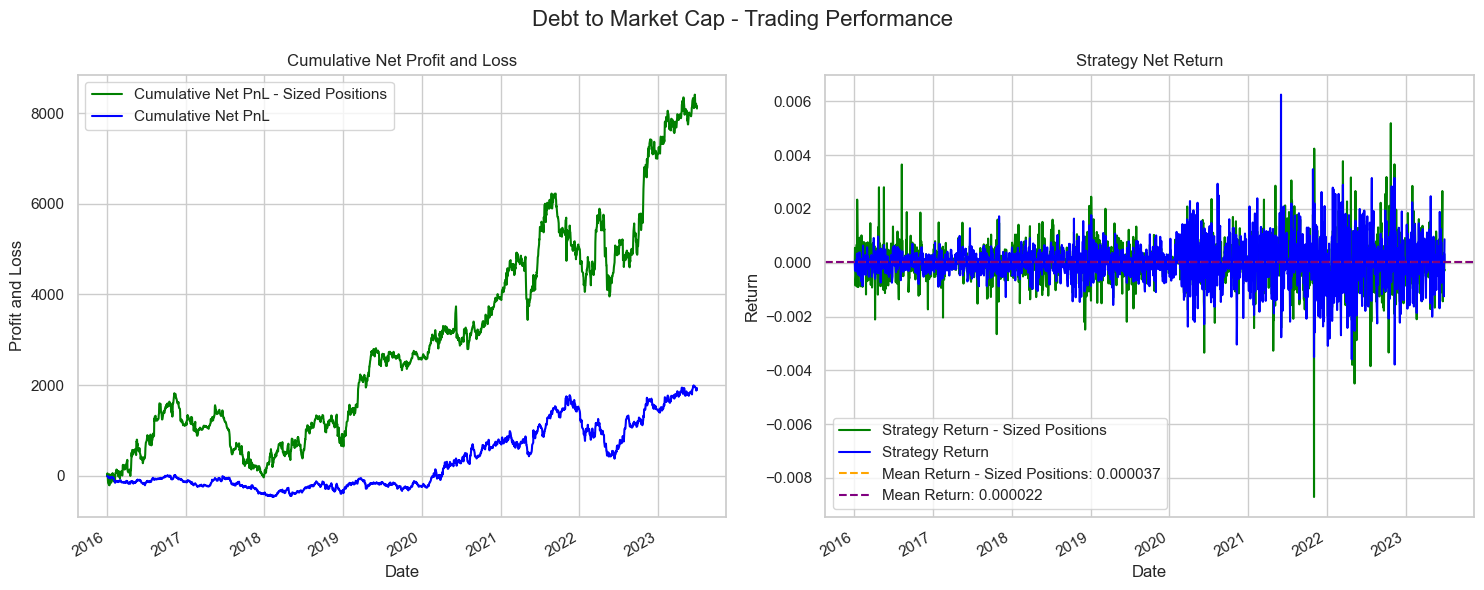

The cumulative profit and loss is $1935.63.
The return on investment is 4.51% with an initial capital of $42885.15.


The cumulative profit and loss with sized positions is $8099.27.
The return on investment with sized positions is 7.83% with an initial capital of $103403.36.


In [49]:
strategy_debt_to_market_cap = QuantileTradingStrategy(df_debt_to_market_cap_daily, df_adj_close_daily, quantile=0.1,
                                                      rates=rates, frequency='M', ascending=True, size_positions=False)

strategy_debt_to_market_cap_sized = QuantileTradingStrategy(df_debt_to_market_cap_daily, df_adj_close_daily,
                                                            quantile=0.1, rates=rates, frequency='M', ascending=True,
                                                            size_positions=True)

debt_to_market_pnl = strategy_debt_to_market_cap.execute_strategy()
debt_to_market_pnl_sized = strategy_debt_to_market_cap_sized.execute_strategy()

display(debt_to_market_pnl.tail())
display(debt_to_market_pnl_sized.tail())

plot_trading_performance(debt_to_market_pnl, debt_to_market_pnl_sized, title='Debt to Market Cap - Trading Performance')

With the Debt to Market Cap ratio, we can see that the strategy is performing pretty well. The cumulative net profit and loss is positive, and the return on investment is also positive. Moreover, we can see that if we size our positions based on their ranking, the performance is even better. As we will see in the next section, the non-annualized mean return is slightly higher when we size our positions, but both strategies still have positive mean returns.

We can note that the cumulative net PnL for the non-sized position (meaning we buy or sell one unit of each equity) is negative before 2020 and then experiences a sharp increase. While the cumulative net PnL for the sized position almost always positive except at the beginning of 2018. It also looks like that more recently, the strategy is experiencing some more volatility than it used to. This is something we will have to keep in mind when we will analyze the performance of the strategy using the other ratios.

,daily_pnl,cumulative_pnl,borrowing_costs,daily_net_pnl,cumulative_net_pnl,ret,cumulative_ret,net_ret,cumulative_net_ret,strategy_return,cumulative_strategy_return,portfolio_capital
date,,,,,,,,,,,,
2023-06-26,-6.985910,8245.658957,-0.077191,-7.063101,8102.007591,-0.000114,0.140938,-0.000115,0.138275,-0.000102,0.131806,69571.713158
2023-06-27,240.676253,8486.335210,-0.078911,240.597342,8342.604933,0.003915,0.145406,0.003914,0.142731,0.003458,0.135720,69812.310500
2023-06-28,-35.222182,8451.113028,-0.079356,-35.301538,8307.303395,-0.000573,0.144749,-0.000574,0.142075,-0.000506,0.135145,69777.008963
2023-06-29,53.621261,8504.734289,-0.079590,53.541671,8360.845066,0.000872,0.145748,0.000871,0.143069,0.000767,0.136016,69830.550634
2023-06-30,155.839744,8660.574033,-0.080560,155.759183,8516.604250,0.002535,0.148653,0.002534,0.145966,0.002231,0.138550,69986.309817


,daily_pnl,cumulative_pnl,borrowing_costs,daily_net_pnl,cumulative_net_pnl,ret,cumulative_ret,net_ret,cumulative_net_ret,strategy_return,cumulative_strategy_return,portfolio_capital
date,,,,,,,,,,,,
2023-06-26,93.417080,12437.716952,-0.164614,93.252466,12150.066978,0.000997,0.137273,0.000995,0.133789,0.000881,0.129610,105893.765147
2023-06-27,243.582878,12681.299830,-0.165906,243.416973,12393.483950,0.002598,0.140228,0.002597,0.136733,0.002299,0.132207,106137.182120
2023-06-28,-114.219292,12567.080538,-0.169535,-114.388827,12279.095123,-0.001218,0.138839,-0.001220,0.135346,-0.001078,0.130987,106022.793292
2023-06-29,80.938311,12648.018849,-0.170344,80.767966,12359.863090,0.000863,0.139822,0.000862,0.136324,0.000762,0.131848,106103.561259
2023-06-30,202.545050,12850.563900,-0.172680,202.372371,12562.235461,0.002161,0.142285,0.002159,0.138777,0.001907,0.134007,106305.933630


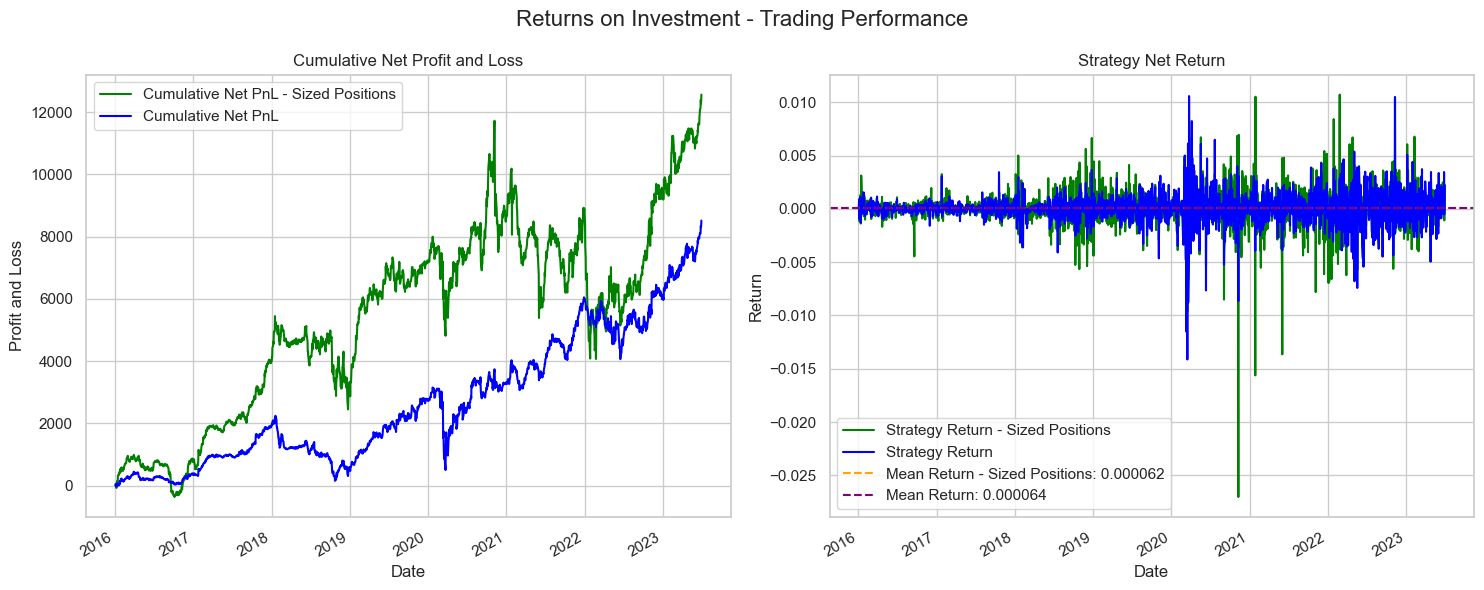

The cumulative profit and loss is $8516.60.
The return on investment is 13.86% with an initial capital of $61469.67.


The cumulative profit and loss with sized positions is $12562.24.
The return on investment with sized positions is 13.40% with an initial capital of $93743.63.


In [50]:
strategy_returns_on_investment = QuantileTradingStrategy(df_returns_on_investment_daily, df_adj_close_daily,
                                                         quantile=0.1, rates=rates, frequency='M', ascending=False,
                                                         size_positions=False)

strategy_returns_on_investment_sized = QuantileTradingStrategy(df_returns_on_investment_daily, df_adj_close_daily,
                                                               quantile=0.1, rates=rates, frequency='M',
                                                               ascending=False, size_positions=True)

returns_on_investment_pnl = strategy_returns_on_investment.execute_strategy()
returns_on_investment_pnl_sized = strategy_returns_on_investment_sized.execute_strategy()

display(returns_on_investment_pnl.tail())
display(returns_on_investment_pnl_sized.tail())

plot_trading_performance(returns_on_investment_pnl, returns_on_investment_pnl_sized,
                         title='Returns on Investment - Trading Performance')

Using the Returns on Investment ratio now, we can see that the strategy is performing well too. The cumulative net profit and loss is positive on the quasi-entire period, and the return on investment of our strategy is also positive. Nevertheless, we can see here that if we size our positions based on their ranking, the performance is not a lot better than without sizing. On the contrary, the non-sized strategy is less volatile because we put less weight on the top and bottom deciles. Therefore, we are less strongly exposed to changes in those securities. Maybe it's also because this ratio has less forecasting power on how well will perform the considered securities.

,daily_pnl,cumulative_pnl,borrowing_costs,daily_net_pnl,cumulative_net_pnl,ret,cumulative_ret,net_ret,cumulative_net_ret,strategy_return,cumulative_strategy_return,portfolio_capital
date,,,,,,,,,,,,
2023-06-26,-23.410146,-494.739483,-0.089471,-23.499617,-660.844013,-0.000665,-0.014985,-0.000667,-0.019620,-0.000680,-0.018763,34558.017743
2023-06-27,20.981786,-473.757696,-0.090786,20.891001,-639.953012,0.000596,-0.014398,0.000593,-0.019039,0.000605,-0.018169,34578.908744
2023-06-28,3.070335,-470.687361,-0.091060,2.979275,-636.973737,0.000087,-0.014312,0.000085,-0.018956,0.000086,-0.018085,34581.888019
2023-06-29,-23.403725,-494.091087,-0.092016,-23.495742,-660.469479,-0.000665,-0.014967,-0.000667,-0.019610,-0.000679,-0.018752,34558.392277
2023-06-30,24.343135,-469.747952,-0.092673,24.250462,-636.219016,0.000691,-0.014287,0.000689,-0.018935,0.000702,-0.018063,34582.642740


,daily_pnl,cumulative_pnl,borrowing_costs,daily_net_pnl,cumulative_net_pnl,ret,cumulative_ret,net_ret,cumulative_net_ret,strategy_return,cumulative_strategy_return,portfolio_capital
date,,,,,,,,,,,,
2023-06-26,-108.435226,3211.866572,-0.154105,-108.589332,2901.297339,-0.001048,0.021621,-0.001050,0.018559,-0.001020,0.028050,106337.676337
2023-06-27,221.663060,3433.529632,-0.156107,221.506953,3122.804292,0.002143,0.023811,0.002141,0.020740,0.002083,0.030192,106559.183290
2023-06-28,181.195465,3614.725097,-0.156286,181.039179,3303.843471,0.001752,0.025604,0.001750,0.022526,0.001699,0.031942,106740.222469
2023-06-29,-165.373779,3449.351317,-0.157912,-165.531691,3138.311780,-0.001599,0.023965,-0.001600,0.020890,-0.001551,0.030342,106574.690778
2023-06-30,320.768738,3770.120056,-0.159151,320.609587,3458.921366,0.003101,0.027140,0.003100,0.024054,0.003008,0.033441,106895.300365


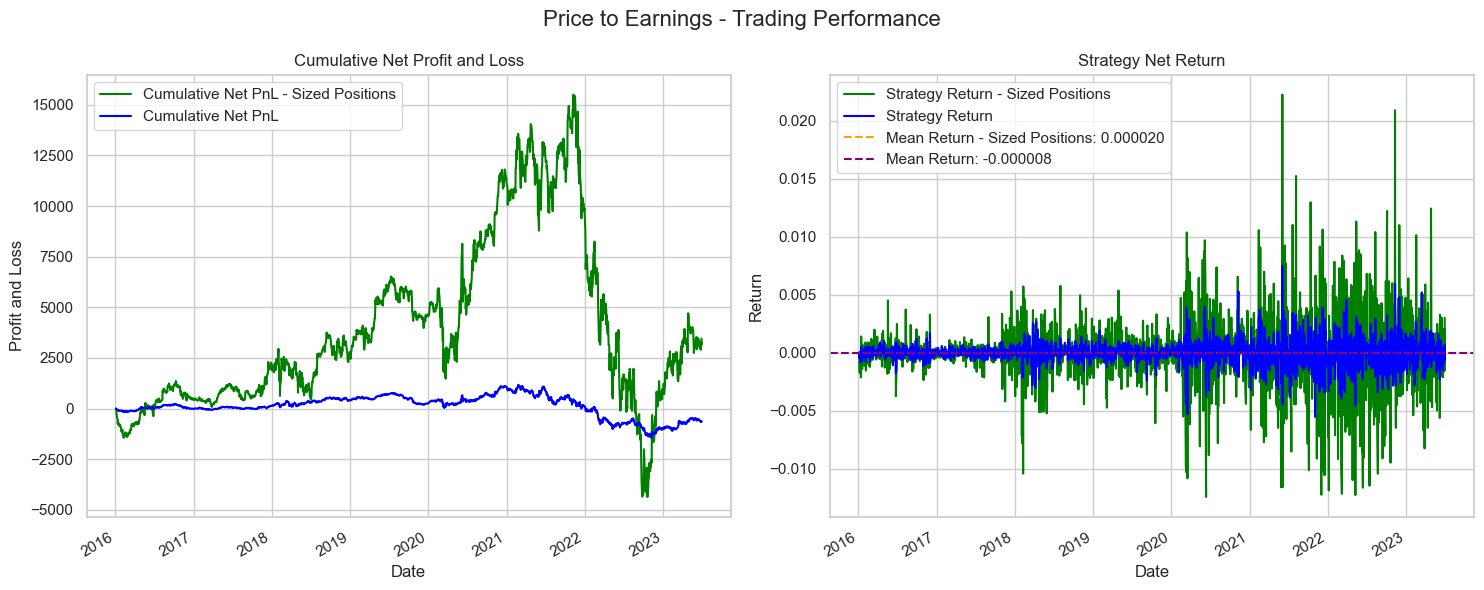

The cumulative profit and loss is $-636.22.
The return on investment is -1.81% with an initial capital of $35218.81.


The cumulative profit and loss with sized positions is $3458.92.
The return on investment with sized positions is 3.34% with an initial capital of $103436.28.


In [51]:
strategy_price_to_earnings = QuantileTradingStrategy(df_price_to_earnings_daily, df_adj_close_daily, quantile=0.1,
                                                     rates=rates, frequency='M', ascending=False, size_positions=False)

strategy_price_to_earnings_sized = QuantileTradingStrategy(df_price_to_earnings_daily, df_adj_close_daily, quantile=0.1,
                                                           rates=rates, frequency='M', ascending=False,
                                                           size_positions=True)

price_to_earnings_pnl = strategy_price_to_earnings.execute_strategy()
price_to_earnings_pnl_sized = strategy_price_to_earnings_sized.execute_strategy()

display(price_to_earnings_pnl.tail())
display(price_to_earnings_pnl_sized.tail())

plot_trading_performance(price_to_earnings_pnl, price_to_earnings_pnl_sized,
                         title='Price to Earnings - Trading Performance')

Our results with this last ratio are even worse. If we manage to reach a cumulative net profit and loss that is positive, around \$15,000 in late 2021 for the sized strategy, we then experience a sharp decrease, making the cumulative net profit and loss negative for some time. The non-sized position hardly ever reaches a decent positive cumulative PnL but becomes negative in 2022 instead. The return on investment for that last strategy is negative while the one for the sized strategy is approximately 0.

#### 3.4. Strategy - Quantile Size Variation

A second approach will be to vary the quantile size in order to diversify our position and therefore try to reduce our risk and exposure.

In [52]:
quantiles = [0.05, 0.1, 0.20]

pnl_debt_to_market_cap_q = []
pnl_debt_to_market_cap_q_sized = []

pnl_returns_on_investment_q = []
pnl_returns_on_investment_q_sized = []

pnl_price_to_earnings_q = []
pnl_price_to_earnings_q_sized = []

for quantile in quantiles:
    strategy_debt_to_market_cap_q = QuantileTradingStrategy(df_debt_to_market_cap_daily, df_adj_close_daily,
                                                            quantile=quantile, rates=rates, frequency='M',
                                                            ascending=True, size_positions=False)

    pnl_debt_to_market_cap_q.append(strategy_debt_to_market_cap_q.execute_strategy())

    strategy_debt_to_market_cap_q_sized = QuantileTradingStrategy(df_debt_to_market_cap_daily, df_adj_close_daily,
                                                                  quantile=quantile, rates=rates, frequency='M',
                                                                  ascending=True, size_positions=True)

    pnl_debt_to_market_cap_q_sized.append(strategy_debt_to_market_cap_q_sized.execute_strategy())

    strategy_returns_on_investment_q = QuantileTradingStrategy(df_returns_on_investment_daily, df_adj_close_daily,
                                                               quantile=quantile, rates=rates, frequency='M',
                                                               ascending=False, size_positions=False)

    pnl_returns_on_investment_q.append(strategy_returns_on_investment_q.execute_strategy())

    strategy_returns_on_investment_q_sized = QuantileTradingStrategy(df_returns_on_investment_daily, df_adj_close_daily,
                                                                     quantile=quantile, rates=rates, frequency='M',
                                                                     ascending=False, size_positions=True)

    pnl_returns_on_investment_q_sized.append(strategy_returns_on_investment_q_sized.execute_strategy())

    strategy_price_to_earnings_q = QuantileTradingStrategy(df_price_to_earnings_daily, df_adj_close_daily,
                                                           quantile=quantile, rates=rates, frequency='M',
                                                           ascending=False, size_positions=False)

    pnl_price_to_earnings_q.append(strategy_price_to_earnings_q.execute_strategy())

    strategy_price_to_earnings_q_sized = QuantileTradingStrategy(df_price_to_earnings_daily, df_adj_close_daily,
                                                                 quantile=quantile, rates=rates, frequency='M',
                                                                 ascending=False, size_positions=True)

    pnl_price_to_earnings_q_sized.append(strategy_price_to_earnings_q_sized.execute_strategy())

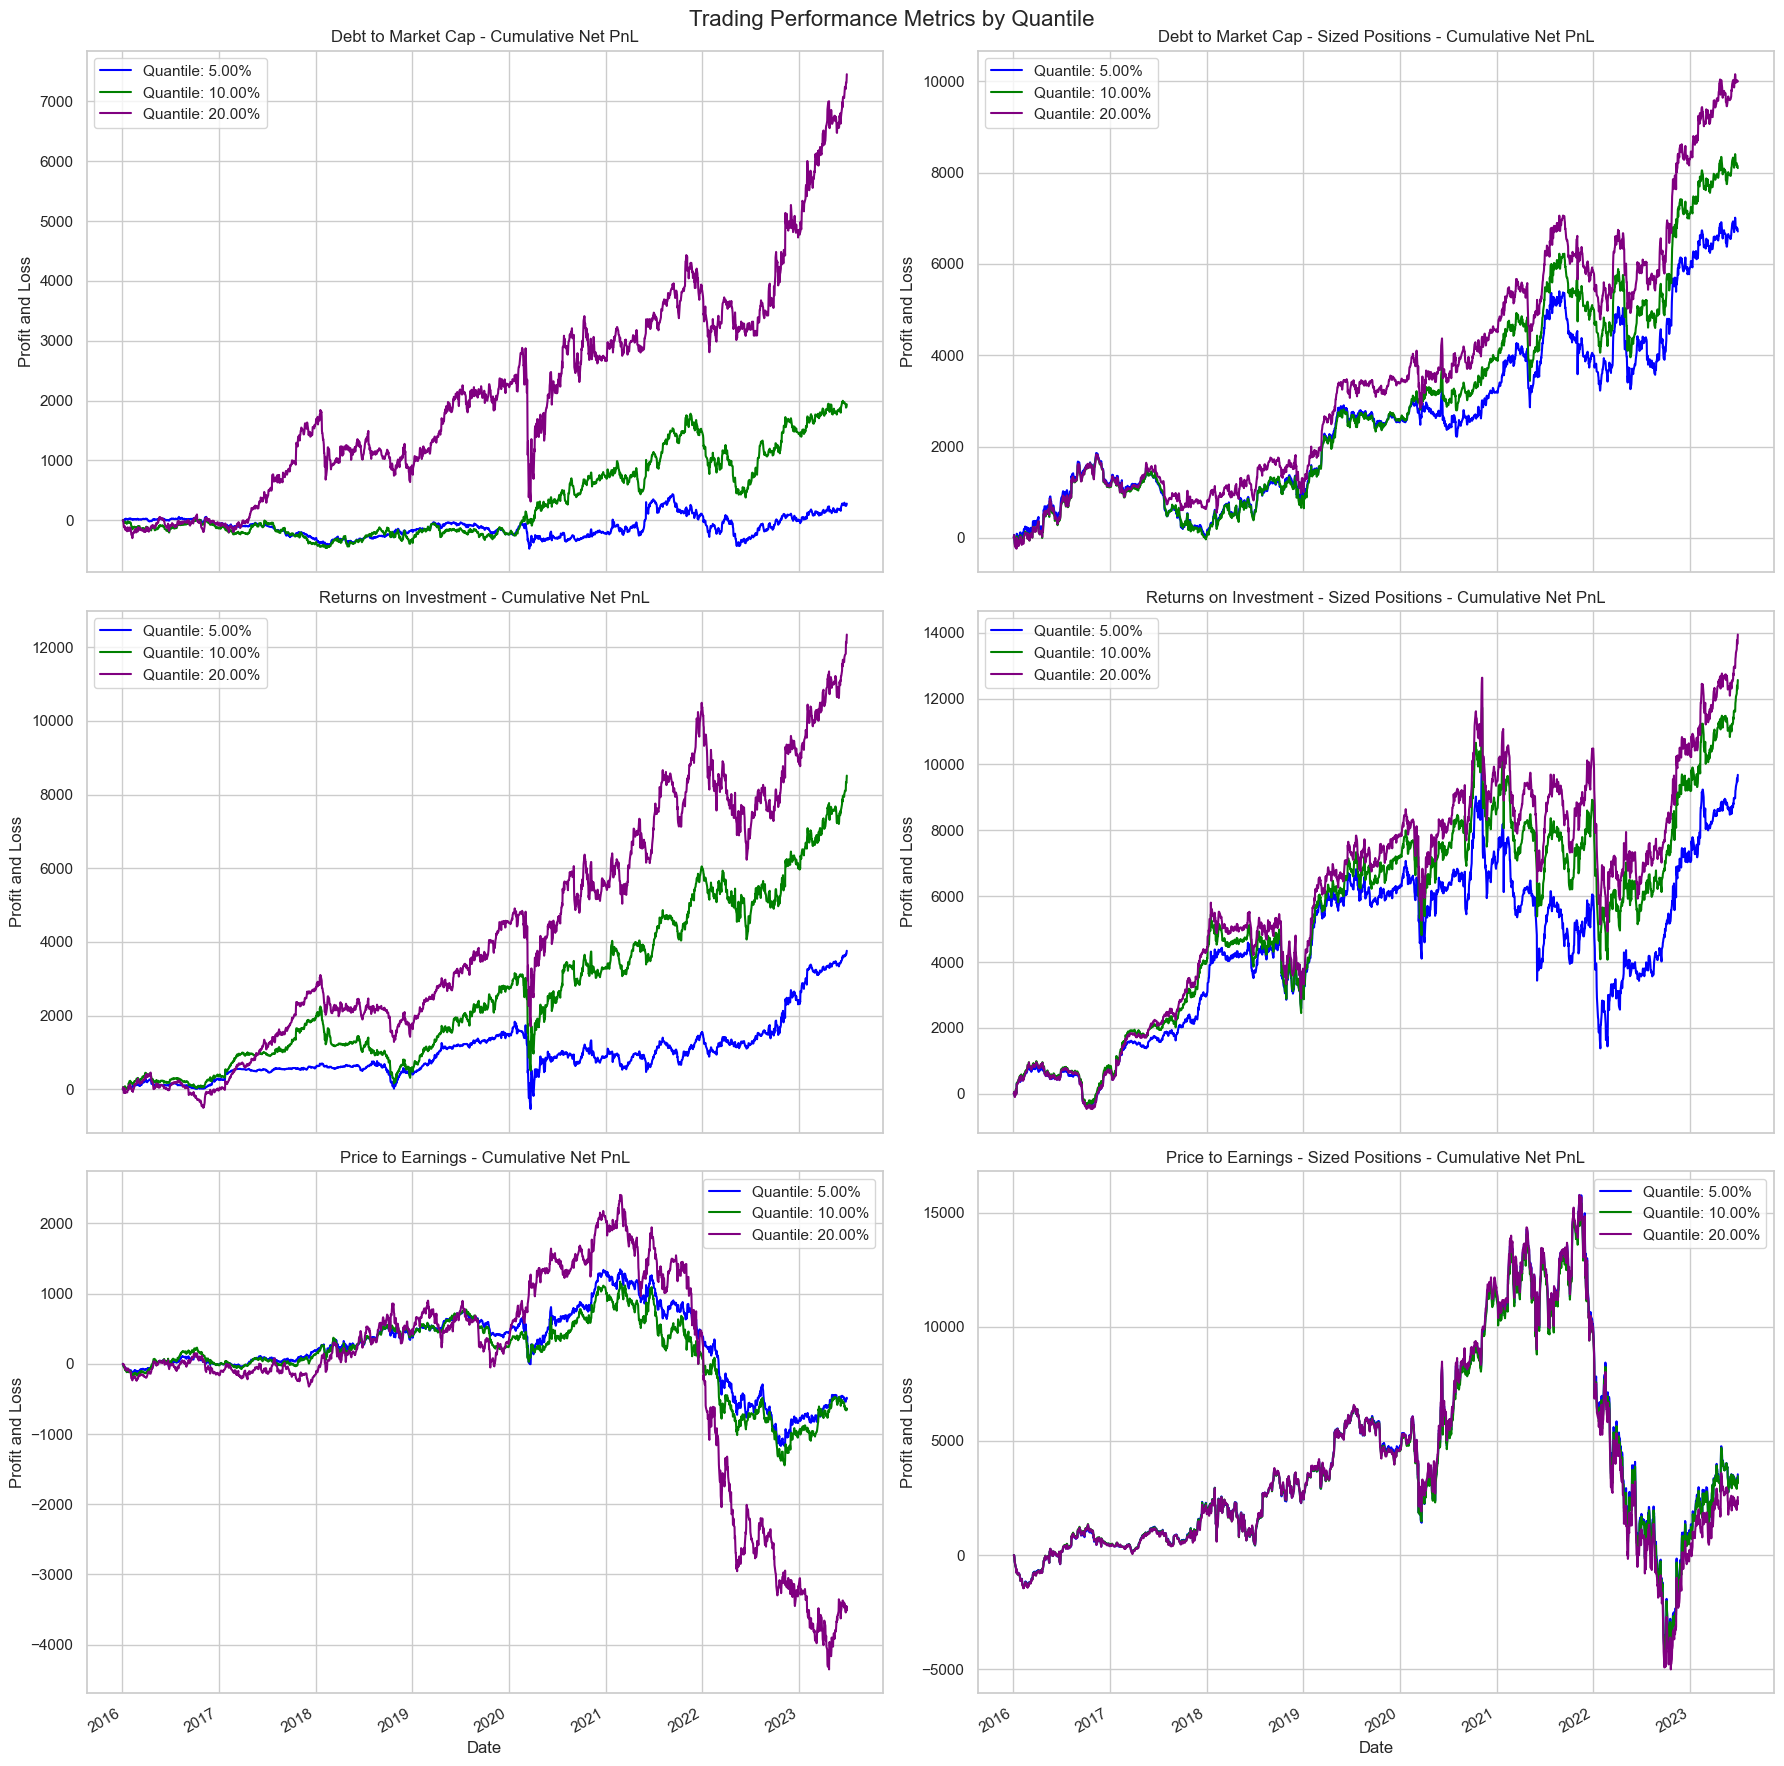

In [53]:
sns.set(style="whitegrid")

strategies = {0: 'Debt to Market Cap', 1: 'Returns on Investment', 2: 'Price to Earnings'}

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18, 18))
fig.suptitle('Trading Performance Metrics by Quantile', fontsize=16)

colors = ['blue', 'green', 'purple']

for i, pnl_group in enumerate([pnl_debt_to_market_cap_q, pnl_returns_on_investment_q, pnl_price_to_earnings_q]):
    for q, pnl in enumerate(pnl_group):
        sns.lineplot(x='date', y='cumulative_net_pnl', data=pnl, ax=axes[i, 0], label=f'Quantile: {quantiles[q]:.2%}',
                     color=colors[q])
    axes[i, 0].set_title(f'{strategies[i]} - Cumulative Net PnL')
    axes[i, 0].set_ylabel('Profit and Loss')
    axes[i, 0].set_xlabel('Date')

for i, pnl_group_sized in enumerate(
        [pnl_debt_to_market_cap_q_sized, pnl_returns_on_investment_q_sized, pnl_price_to_earnings_q_sized]):
    for q, pnl_sized in enumerate(pnl_group_sized):
        sns.lineplot(x='date', y='cumulative_net_pnl', data=pnl_sized, ax=axes[i, 1],
                     label=f'Quantile: {quantiles[q]:.2%}', color=colors[q])
    axes[i, 1].set_title(f'{strategies[i]} - Sized Positions - Cumulative Net PnL')
    axes[i, 1].set_ylabel('Profit and Loss')
    axes[i, 1].set_xlabel('Date')

fig.autofmt_xdate()
plt.tight_layout()
plt.show()

Those graphs are very insightful. We can identify several patterns. The first, and most important, is that the performance of the strategy is not consistent across the different ratios. The strategy using the Returns on Investment ratio is the best in terms of cumulative PnL, with or without position sizing but also for all the quantiles computed. It is followed by the strategy using the Debt to Market Cap and finally by the one using Price to Earnings.

It appears that apart from the strategy using the price to earnings without sizing the positions, the larger the quantile, the better the performance. This is not surprising since the top and bottom deciles are the most extreme cases and therefore the most likely to experience a change in their performance. Also, by taking a larger quantile, we diversify our position and reduce our risk and exposure, but it looks like we still have some large volatility since we are now exposed to more securities, especially when we are not sizing the positions.

Indeed, sizing our positions makes our cumulative PnL for the different quantiles very close to each other. We take more tickers but we do not weigh the additional new tickers with the same weigh as the others. Therefore, we do not add a large volatility component but instead more diversification. We could see the sizing mechanism as a little counterbalance to the quantile size, helping us reach high cumulative PnL with a smaller quantile.

#### 3.5. Strategy - Changes in Ratios

Now what about if we rank our US equities based on changes in the ratios rather than the ratios themselves. Let's see if the results we obtained before are consistent with the ones we are going to obtain now.

In [54]:
df_debt_to_market_cap_daily_changes = df_debt_to_market_cap.pct_change().replace(0, np.nan).ffill().dropna().ffill()

df_returns_on_investment_daily_changes = df_returns_on_investment.pct_change().replace(0,
                                                                                       np.nan).ffill().dropna().ffill()

df_price_to_earnings_daily_changes = df_price_to_earnings.pct_change().replace(0, np.nan).ffill().dropna().ffill()

,daily_pnl,cumulative_pnl,borrowing_costs,daily_net_pnl,cumulative_net_pnl,ret,cumulative_ret,net_ret,cumulative_net_ret,strategy_return,cumulative_strategy_return,portfolio_capital
date,,,,,,,,,,,,
2023-06-26,3.147810,-1264.340576,-0.085564,3.062246,-1478.630063,0.000080,-0.033610,0.000078,-0.038844,0.000081,-0.037477,37976.093999
2023-06-27,41.077671,-1223.262905,-0.086214,40.991456,-1437.638607,0.001041,-0.032604,0.001039,-0.037846,0.001079,-0.036438,38017.085456
2023-06-28,38.451664,-1184.811241,-0.085292,38.366372,-1399.272235,0.000975,-0.031661,0.000972,-0.036910,0.001009,-0.035465,38055.451828
2023-06-29,6.095146,-1178.716095,-0.086041,6.009105,-1393.263130,0.000154,-0.031511,0.000152,-0.036763,0.000158,-0.035313,38061.460932
2023-06-30,13.692048,-1165.024048,-0.086938,13.605109,-1379.658021,0.000347,-0.031175,0.000345,-0.036431,0.000357,-0.034968,38075.066041


,daily_pnl,cumulative_pnl,borrowing_costs,daily_net_pnl,cumulative_net_pnl,ret,cumulative_ret,net_ret,cumulative_net_ret,strategy_return,cumulative_strategy_return,portfolio_capital
date,,,,,,,,,,,,
2023-06-26,46.381715,8656.349392,-0.151337,46.230377,8220.072010,0.000577,0.103765,0.000575,0.097796,0.000522,0.102186,88662.679321
2023-06-27,92.357280,8748.706672,-0.152039,92.205241,8312.277250,0.001148,0.105033,0.001146,0.099054,0.001040,0.103332,88754.884562
2023-06-28,26.460324,8775.166996,-0.150887,26.309437,8338.586688,0.000329,0.105396,0.000327,0.099414,0.000296,0.103659,88781.193999
2023-06-29,31.307824,8806.474820,-0.151803,31.156021,8369.742709,0.000389,0.105826,0.000387,0.099840,0.000351,0.104046,88812.350020
2023-06-30,24.724383,8831.199203,-0.153413,24.570971,8394.313680,0.000307,0.106166,0.000305,0.100176,0.000277,0.104352,88836.920991


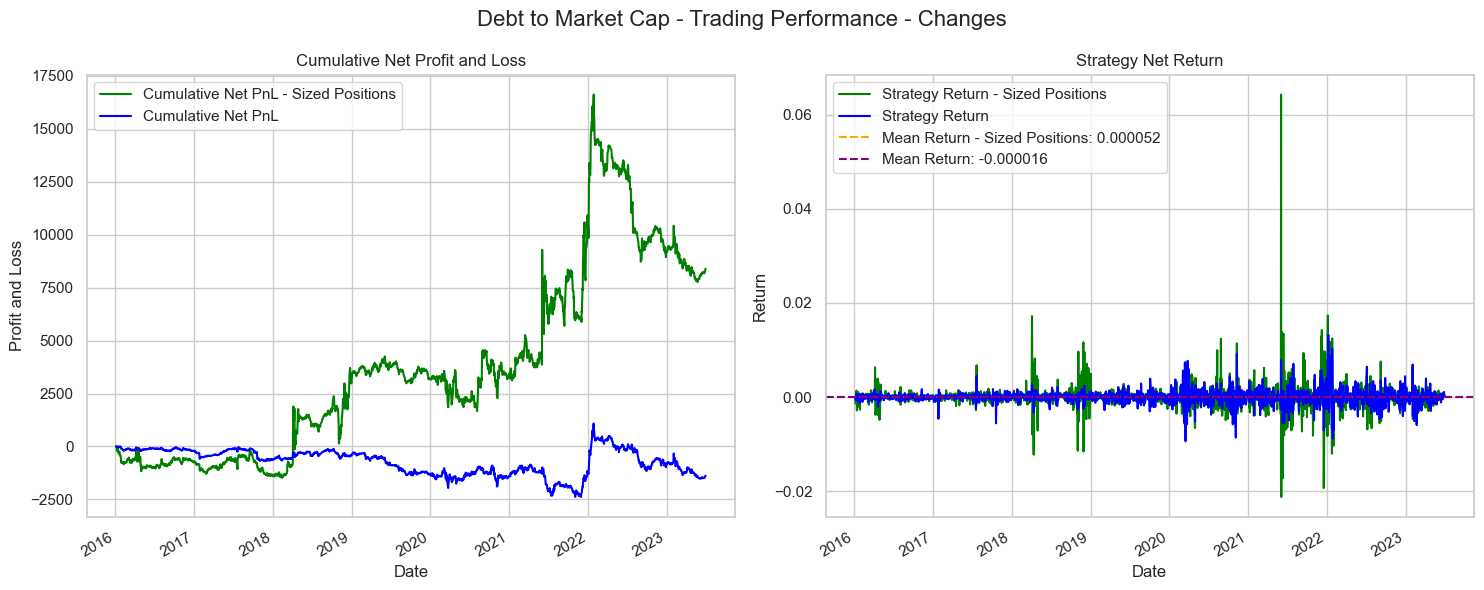

The cumulative profit and loss is $-1379.66.
The return on investment is -3.50% with an initial capital of $39454.72.


The cumulative profit and loss with sized positions is $8394.31.
The return on investment with sized positions is 10.44% with an initial capital of $80442.61.


In [55]:
strategy_debt_to_market_cap_change = QuantileTradingStrategy(df_debt_to_market_cap_daily_changes, df_adj_close_daily,
                                                             quantile=0.1, rates=rates, frequency='M', ascending=True,
                                                             size_positions=False)

strategy_debt_to_market_cap_change_sized = QuantileTradingStrategy(df_debt_to_market_cap_daily_changes,
                                                                   df_adj_close_daily, quantile=0.1, rates=rates,
                                                                   frequency='M', ascending=True, size_positions=True)

debt_to_market_pnl_change = strategy_debt_to_market_cap_change.execute_strategy()
debt_to_market_pnl_change_sized = strategy_debt_to_market_cap_change_sized.execute_strategy()

display(debt_to_market_pnl_change.tail())
display(debt_to_market_pnl_change_sized.tail())

plot_trading_performance(debt_to_market_pnl_change, debt_to_market_pnl_change_sized,
                         title='Debt to Market Cap - Trading Performance - Changes')

Contrary to what we observed for the strategy using Debt to Market Cap before, the results using the change in this ratio are less interesting. The cumulative PnL experiences large movement and do not stay positive without sizing the positions. The return plot also show some large outliers and periods with strong movements. We will this later on if this analysis gets confirmed by the tail metrics analysis.

,daily_pnl,cumulative_pnl,borrowing_costs,daily_net_pnl,cumulative_net_pnl,ret,cumulative_ret,net_ret,cumulative_net_ret,strategy_return,cumulative_strategy_return,portfolio_capital
date,,,,,,,,,,,,
2023-06-26,-0.519481,1022.853649,-0.120418,-0.639898,797.259233,-0.000013,0.023599,-0.000016,0.017907,-0.000016,0.019710,41247.617278
2023-06-27,-34.485780,988.367869,-0.122346,-34.608127,762.651106,-0.000853,0.022727,-0.000856,0.017036,-0.000839,0.018854,41213.009152
2023-06-28,-32.993142,955.374727,-0.122438,-33.115580,729.535526,-0.000816,0.021893,-0.000819,0.016203,-0.000804,0.018035,41179.893571
2023-06-29,-10.310712,945.064015,-0.123478,-10.434190,719.101336,-0.000255,0.021632,-0.000258,0.015941,-0.000253,0.017777,41169.459381
2023-06-30,-20.243059,924.820956,-0.125012,-20.368071,698.733265,-0.000500,0.021121,-0.000504,0.015429,-0.000495,0.017274,41149.091310


,daily_pnl,cumulative_pnl,borrowing_costs,daily_net_pnl,cumulative_net_pnl,ret,cumulative_ret,net_ret,cumulative_net_ret,strategy_return,cumulative_strategy_return,portfolio_capital
date,,,,,,,,,,,,
2023-06-26,-30.967306,-6619.219323,-0.218452,-31.185758,-7094.158353,-0.000333,-0.074561,-0.000335,-0.079275,-0.000363,-0.076274,85914.990141
2023-06-27,-85.523630,-6704.742954,-0.221789,-85.745420,-7179.903773,-0.000920,-0.075412,-0.000922,-0.080124,-0.000998,-0.077196,85829.244721
2023-06-28,-37.937493,-6742.680446,-0.221679,-38.159171,-7218.062944,-0.000408,-0.075789,-0.000410,-0.080502,-0.000445,-0.077606,85791.085549
2023-06-29,-30.476648,-6773.157094,-0.223486,-30.700134,-7248.763079,-0.000328,-0.076092,-0.000330,-0.080805,-0.000358,-0.077936,85760.385415
2023-06-30,-25.800662,-6798.957756,-0.225888,-26.026549,-7274.789628,-0.000277,-0.076348,-0.000280,-0.081062,-0.000303,-0.078216,85734.358866


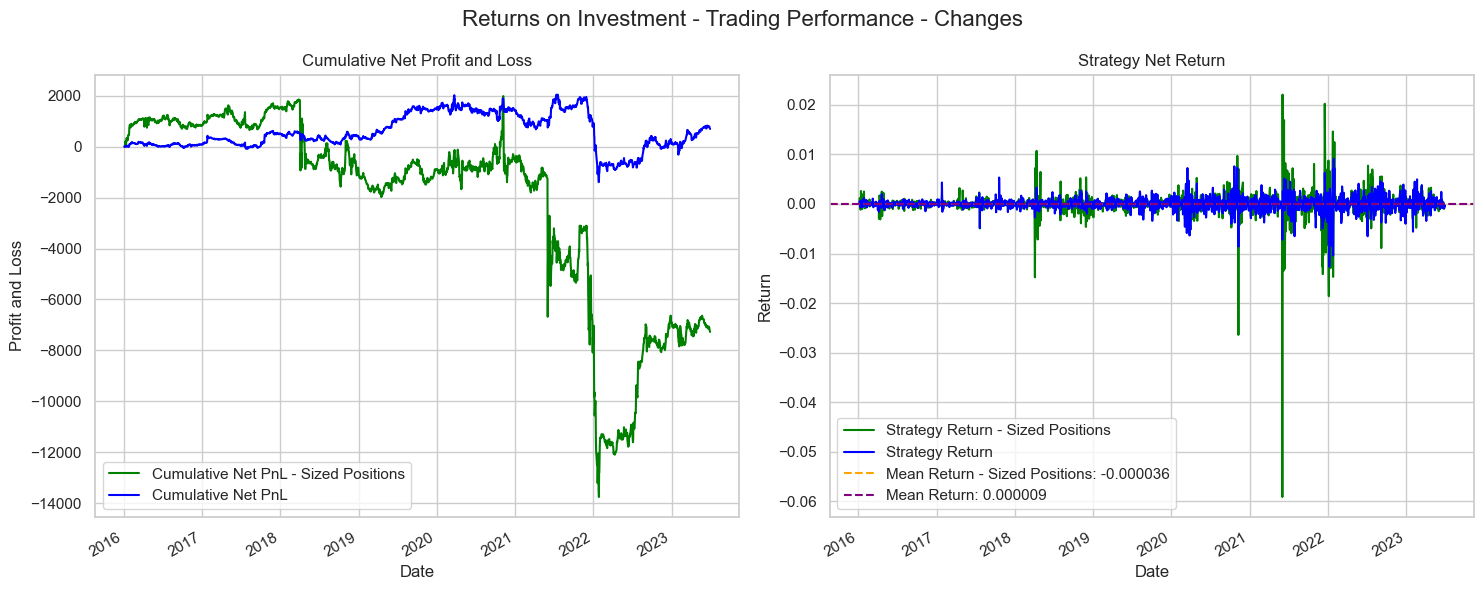

The cumulative profit and loss is $698.73.
The return on investment is 1.73% with an initial capital of $40450.36.


The cumulative profit and loss with sized positions is $-7274.79.
The return on investment with sized positions is -7.82% with an initial capital of $93009.15.


In [56]:
strategy_returns_on_investment_change = QuantileTradingStrategy(df_returns_on_investment_daily_changes,
                                                                df_adj_close_daily, quantile=0.1, rates=rates,
                                                                frequency='M', ascending=False, size_positions=False)

strategy_returns_on_investment_change_sized = QuantileTradingStrategy(df_returns_on_investment_daily_changes,
                                                                      df_adj_close_daily, quantile=0.1, rates=rates,
                                                                      frequency='M', ascending=False,
                                                                      size_positions=True)

returns_on_investment_pnl_change = strategy_returns_on_investment_change.execute_strategy()
returns_on_investment_pnl_change_sized = strategy_returns_on_investment_change_sized.execute_strategy()

display(returns_on_investment_pnl_change.tail())
display(returns_on_investment_pnl_change_sized.tail())

plot_trading_performance(returns_on_investment_pnl_change, returns_on_investment_pnl_change_sized,
                         title='Returns on Investment - Trading Performance - Changes')

It gets even worse for the strategy using the changes in the Returns on Investment ratio. The cumulative PnL is negative for the sized strategy and positive but small for the non-sized strategy. We can draw the same picture as before, with some outliers returns, depicted by large movements in our cumulative PnL.

,daily_pnl,cumulative_pnl,borrowing_costs,daily_net_pnl,cumulative_net_pnl,ret,cumulative_ret,net_ret,cumulative_net_ret,strategy_return,cumulative_strategy_return,portfolio_capital
date,,,,,,,,,,,,
2023-06-26,3.147810,-1515.853897,-0.085564,3.062246,-1732.731367,0.000080,-0.039777,0.000078,-0.045040,0.000081,-0.043917,37721.992696
2023-06-27,41.077671,-1474.776226,-0.086214,40.991456,-1691.739910,0.001041,-0.038777,0.001039,-0.044048,0.001087,-0.042878,37762.984152
2023-06-28,38.451664,-1436.324562,-0.085292,38.366372,-1653.373538,0.000975,-0.037840,0.000972,-0.043119,0.001016,-0.041906,37801.350524
2023-06-29,6.095146,-1430.229416,-0.086041,6.009105,-1647.364434,0.000154,-0.037692,0.000152,-0.042973,0.000159,-0.041753,37807.359629
2023-06-30,13.692048,-1416.537368,-0.086938,13.605109,-1633.759325,0.000347,-0.037358,0.000345,-0.042643,0.000360,-0.041408,37820.964738


,daily_pnl,cumulative_pnl,borrowing_costs,daily_net_pnl,cumulative_net_pnl,ret,cumulative_ret,net_ret,cumulative_net_ret,strategy_return,cumulative_strategy_return,portfolio_capital
date,,,,,,,,,,,,
2023-06-26,46.381715,4377.218750,-0.151337,46.230377,3935.274690,0.000577,0.047298,0.000575,0.041560,0.000548,0.048920,84377.882001
2023-06-27,92.357280,4469.576030,-0.152039,92.205241,4027.479931,0.001148,0.048500,0.001146,0.042754,0.001093,0.050067,84470.087242
2023-06-28,26.460324,4496.036354,-0.150887,26.309437,4053.789368,0.000329,0.048845,0.000327,0.043095,0.000311,0.050394,84496.396679
2023-06-29,31.307824,4527.344178,-0.151803,31.156021,4084.945389,0.000389,0.049253,0.000387,0.043499,0.000369,0.050781,84527.552700
2023-06-30,24.724383,4552.068561,-0.153413,24.570971,4109.516360,0.000307,0.049576,0.000305,0.043818,0.000291,0.051086,84552.123671


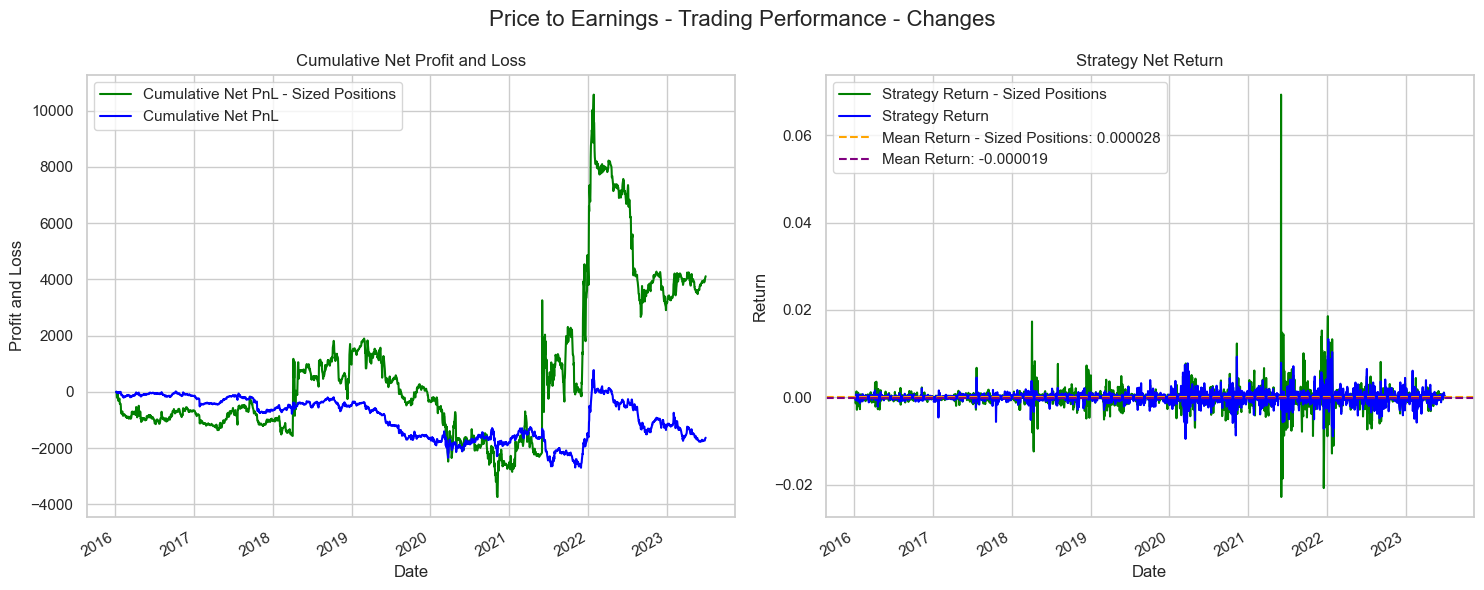

The cumulative profit and loss is $-1633.76.
The return on investment is -4.14% with an initial capital of $39454.72.


The cumulative profit and loss with sized positions is $4109.52.
The return on investment with sized positions is 5.11% with an initial capital of $80442.61.


In [57]:
strategy_price_to_earnings_change = QuantileTradingStrategy(df_price_to_earnings_daily_changes, df_adj_close_daily,
                                                            quantile=0.1, rates=rates, frequency='M', ascending=False,
                                                            size_positions=False)

strategy_price_to_earnings_change_sized = QuantileTradingStrategy(df_price_to_earnings_daily_changes,
                                                                  df_adj_close_daily,
                                                                  quantile=0.1, rates=rates, frequency='M',
                                                                  ascending=False, size_positions=True)

price_to_earnings_pnl_change = strategy_price_to_earnings_change.execute_strategy()
price_to_earnings_pnl_change_sized = strategy_price_to_earnings_change_sized.execute_strategy()

display(price_to_earnings_pnl_change.tail())
display(price_to_earnings_pnl_change_sized.tail())

plot_trading_performance(price_to_earnings_pnl_change, price_to_earnings_pnl_change_sized,
                         title='Price to Earnings - Trading Performance - Changes')

Finally, the strategy using the changes in the Price to Earnings shows a very similar profile to the one using the Debt to Market Cap ratio changes. The cumulative PnL is positive for the non-sized strategy and negative for the sized strategy. But both experience large movements again.

Using the changes in those ratios does not seem alluring in terms of cumulative realized PnL. As we have seen, without sizing, the strategies do not deliver a positive cumulative PnL. With sizing, it is either a positive or negative PnL but with some large movements and a lot of risk, presumably. Maybe some other metrics can explain those profiles and why they can be interesting for our trading problem.

#### 3.6. Strategy - Composition of Ratios

Let's now try to combine our ratios to see if we can get a better performance. We will use a weighted average of the z-scores of each ratio to create the combined metric.

In [58]:
def calculate_z_score(df):
    return (df - df.mean()) / df.std()

In [59]:
def weighted_average_z_score(weights, dfs):
    weighted_dfs = []

    for weight, df in zip(weights, dfs):
        weighted_dfs.append(df * weight)

    combined_df = sum(weighted_dfs)
    total_weight = sum(weights)

    return combined_df / total_weight

In [60]:
z_score_debt_to_market_cap = calculate_z_score(df_debt_to_market_cap_daily)
z_score_returns_on_investment = calculate_z_score(df_returns_on_investment_daily)
z_score_price_to_earnings = calculate_z_score(df_price_to_earnings_daily)

weights = [0.5, 0.3, 0.2]  # Weights chosen arbitrarily
z_scores = [z_score_debt_to_market_cap, z_score_returns_on_investment, z_score_price_to_earnings]

combined_metric = weighted_average_z_score(weights, z_scores)

,daily_pnl,cumulative_pnl,borrowing_costs,daily_net_pnl,cumulative_net_pnl,ret,cumulative_ret,net_ret,cumulative_net_ret,strategy_return,cumulative_strategy_return,portfolio_capital
date,,,,,,,,,,,,
2023-06-26,-53.622463,2033.814609,-0.117208,-53.739670,1793.547261,-0.001318,0.049720,-0.001320,0.043541,-0.001263,0.044070,42492.772336
2023-06-27,187.864268,2221.678878,-0.118566,187.745702,1981.292963,0.004616,0.054565,0.004613,0.048355,0.004418,0.048683,42680.518038
2023-06-28,20.061872,2241.740750,-0.117811,19.944061,2001.237024,0.000493,0.055085,0.000490,0.048869,0.000467,0.049173,42700.462099
2023-06-29,-13.651282,2228.089467,-0.118465,-13.769747,1987.467277,-0.000335,0.054731,-0.000338,0.048514,-0.000322,0.048835,42686.692351
2023-06-30,67.568229,2295.657696,-0.119778,67.448450,2054.915727,0.001660,0.056482,0.001657,0.050251,0.001580,0.050492,42754.140802


,daily_pnl,cumulative_pnl,borrowing_costs,daily_net_pnl,cumulative_net_pnl,ret,cumulative_ret,net_ret,cumulative_net_ret,strategy_return,cumulative_strategy_return,portfolio_capital
date,,,,,,,,,,,,
2023-06-26,-92.530123,14299.732198,-0.295200,-92.825323,13831.717596,-0.001344,0.226741,-0.001349,0.218428,-0.001122,0.200981,82653.389471
2023-06-27,189.377808,14489.110006,-0.298194,189.079614,14020.797210,0.002752,0.230117,0.002747,0.221776,0.002288,0.203728,82842.469085
2023-06-28,129.716166,14618.826172,-0.296185,129.419981,14150.217191,0.001885,0.232436,0.001881,0.224073,0.001562,0.205609,82971.889067
2023-06-29,-23.296468,14595.529704,-0.297318,-23.593786,14126.623405,-0.000339,0.232018,-0.000343,0.223654,-0.000284,0.205266,82948.295281
2023-06-30,51.800788,14647.330492,-0.300858,51.499930,14178.123336,0.000753,0.232946,0.000748,0.224569,0.000621,0.206014,82999.795211


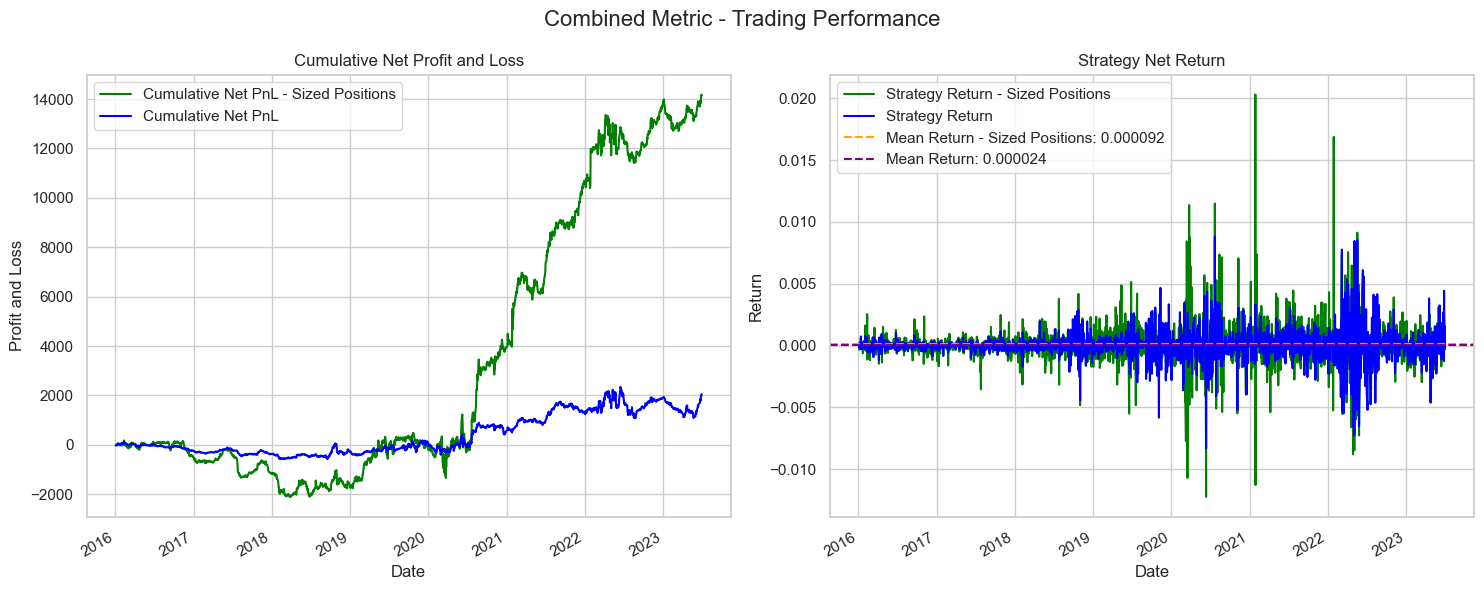

The cumulative profit and loss is $2054.92.
The return on investment is 5.05% with an initial capital of $40699.16.


The cumulative profit and loss with sized positions is $14178.12.
The return on investment with sized positions is 20.60% with an initial capital of $68821.57.


In [61]:
strategy_combined_metric = QuantileTradingStrategy(combined_metric, df_adj_close_daily, quantile=0.1, rates=rates,
                                                   frequency='M', ascending=True, size_positions=False)

strategy_combined_metric_sized = QuantileTradingStrategy(combined_metric, df_adj_close_daily, quantile=0.1, rates=rates,
                                                         frequency='M', ascending=True, size_positions=True)

combined_metric_pnl = strategy_combined_metric.execute_strategy()
combined_metric_pnl_sized = strategy_combined_metric_sized.execute_strategy()

display(combined_metric_pnl.tail())
display(combined_metric_pnl_sized.tail())

plot_trading_performance(combined_metric_pnl, combined_metric_pnl_sized, title='Combined Metric - Trading Performance')

The performance of our combined metric is alluring. The cumulative net profit and loss is always positive after the beginning of 2020, along with the return on investment. We can see that if we size our positions based on their ranking, the performance is even better, with a huge scale factor compared to the strategy without sized positions. The non-annualized mean return is higher when we size our positions, but both strategies still have positive mean returns. It also looks like the strategies are experiencing less volatility than the ones using the single ratios. This is something we will have to keep in mind when we will analyze the performance of the strategy using the other ratios to see if this appears in the metrics.

We can legitimately think that mixing our ratios allows for more performance. As a reminder, the weights were chosen arbitrarily. We will now try to optimize them using Optuna.

#### 3.7. Strategy - Optuna Optimization

Just for fun, let's try to optimize the weights of our combined metric and the parameters of our strategy using Optuna.

In [62]:
def objective(trial):
    weight_1 = trial.suggest_float('weight_1', 0, 1)
    weight_2 = trial.suggest_float('weight_2', 0, 1 - weight_1)
    weight_3 = 1 - weight_1 - weight_2

    ascending = trial.suggest_categorical('ascending', [True, False])
    size_positions = trial.suggest_categorical('size_positions', [True, False])
    quantile = trial.suggest_float('quantile', 0.05, 0.3)

    z_scores = [z_score_debt_to_market_cap, z_score_returns_on_investment, z_score_price_to_earnings]
    combined_metric = weighted_average_z_score([weight_1, weight_2, weight_3], z_scores)

    strategy = QuantileTradingStrategy(
        combined_metric,
        df_adj_close_daily,
        quantile=quantile,
        rates=rates,
        frequency='M',
        ascending=ascending,
        size_positions=size_positions
    )

    pnl = strategy.execute_strategy()

    return pnl['cumulative_net_pnl'].iloc[-1]


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print('Best trial:', study.best_trial.params)

[I 2024-02-01 21:16:47,555] A new study created in memory with name: no-name-6f48c079-0bfc-43a2-999d-188b6a5c8fef
[I 2024-02-01 21:16:47,742] Trial 0 finished with value: 23983.17989023692 and parameters: {'weight_1': 0.36638040220700274, 'weight_2': 0.03164308555939722, 'ascending': True, 'size_positions': True, 'quantile': 0.12966147949101275}. Best is trial 0 with value: 23983.17989023692.
[I 2024-02-01 21:16:47,929] Trial 1 finished with value: 6639.862798813778 and parameters: {'weight_1': 0.9683835216549567, 'weight_2': 0.00900650676109268, 'ascending': True, 'size_positions': True, 'quantile': 0.1663889407449916}. Best is trial 0 with value: 23983.17989023692.
[I 2024-02-01 21:16:48,110] Trial 2 finished with value: 915.2833246037733 and parameters: {'weight_1': 0.9874930986191375, 'weight_2': 0.0040446317936282125, 'ascending': False, 'size_positions': False, 'quantile': 0.19701819012203226}. Best is trial 0 with value: 23983.17989023692.
[I 2024-02-01 21:16:48,403] Trial 3 fin

Best trial: {'weight_1': 0.15558767919569164, 'weight_2': 0.1848145585566871, 'ascending': True, 'size_positions': True, 'quantile': 0.10906090031365004}


,daily_pnl,cumulative_pnl,borrowing_costs,daily_net_pnl,cumulative_net_pnl,ret,cumulative_ret,net_ret,cumulative_net_ret,strategy_return,cumulative_strategy_return,portfolio_capital
date,,,,,,,,,,,,
2023-06-26,-25.556571,7936.911542,-0.163102,-25.719673,7685.227172,-0.000572,0.193319,-0.000576,0.186611,-0.000491,0.172149,52328.484389
2023-06-27,136.070684,8072.982226,-0.165314,135.905370,7821.132542,0.003048,0.196956,0.003044,0.190223,0.002597,0.175194,52464.389759
2023-06-28,8.613655,8081.595881,-0.165533,8.448122,7829.580665,0.000193,0.197187,0.000189,0.190448,0.000161,0.175383,52472.837882
2023-06-29,-32.473672,8049.122209,-0.166285,-32.639956,7796.940708,-0.000727,0.196316,-0.000731,0.189578,-0.000622,0.174652,52440.197925
2023-06-30,32.584469,8081.706678,-0.168732,32.415737,7829.356445,0.000730,0.197189,0.000726,0.190442,0.000618,0.175378,52472.613662


,daily_pnl,cumulative_pnl,borrowing_costs,daily_net_pnl,cumulative_net_pnl,ret,cumulative_ret,net_ret,cumulative_net_ret,strategy_return,cumulative_strategy_return,portfolio_capital
date,,,,,,,,,,,,
2023-06-26,6.584287,33336.001483,-0.291269,6.293018,32843.509059,0.000090,0.566362,0.000086,0.555876,0.000059,0.448087,106140.951154
2023-06-27,221.175847,33557.177329,-0.296166,220.879680,33064.388739,0.003018,0.571089,0.003013,0.560565,0.002081,0.451101,106361.830835
2023-06-28,147.008000,33704.185329,-0.296562,146.711438,33211.100177,0.002006,0.574240,0.002002,0.563688,0.001379,0.453103,106508.542273
2023-06-29,-102.489512,33601.695817,-0.298491,-102.788003,33108.312174,-0.001398,0.572039,-0.001402,0.561495,-0.000965,0.451700,106405.754269
2023-06-30,39.511780,33641.207597,-0.302479,39.209302,33147.521476,0.000539,0.572886,0.000535,0.562331,0.000368,0.452235,106444.963571


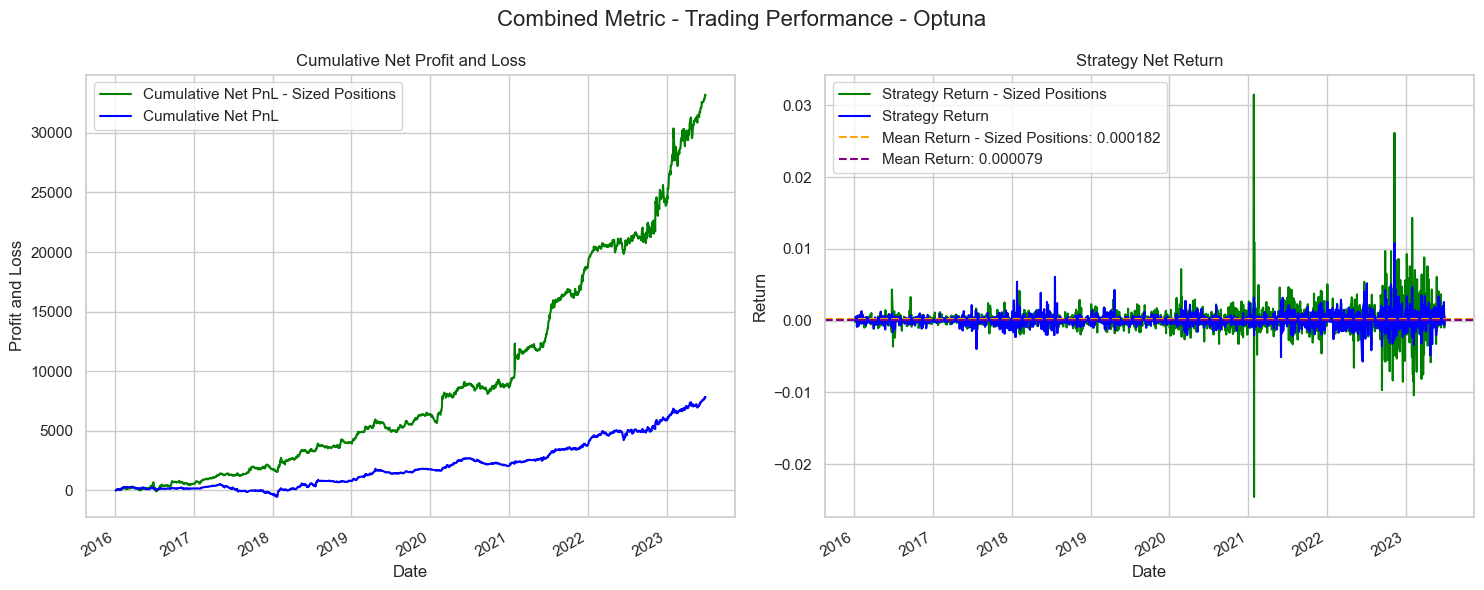

The cumulative profit and loss is $7829.36.
The return on investment is 17.54% with an initial capital of $44643.19.


The cumulative profit and loss with sized positions is $33147.52.
The return on investment with sized positions is 45.22% with an initial capital of $73297.33.


In [63]:
best_weights = [study.best_params[f'weight_{i}'] for i in range(1, 3)]
best_weights.append(1 - sum(best_weights))

combined_metric_optuna = weighted_average_z_score(best_weights, z_scores)

strategy_combined_metric_optuna = QuantileTradingStrategy(combined_metric_optuna, df_adj_close_daily,
                                                          quantile=study.best_params['quantile'], rates=rates,
                                                          frequency='M',
                                                          ascending=True, size_positions=False)

strategy_combined_metric_optuna_sized = QuantileTradingStrategy(combined_metric_optuna, df_adj_close_daily,
                                                                quantile=study.best_params['quantile'], rates=rates,
                                                                frequency='M',
                                                                ascending=True, size_positions=True)

combined_metric_pnl_optuna = strategy_combined_metric_optuna.execute_strategy()
combined_metric_pnl_optuna_sized = strategy_combined_metric_optuna_sized.execute_strategy()

display(combined_metric_pnl_optuna.tail())
display(combined_metric_pnl_optuna_sized.tail())

plot_trading_performance(combined_metric_pnl_optuna, combined_metric_pnl_optuna_sized,
                         title='Combined Metric - Trading Performance - Optuna')

As could have maybe been expected, the optimization of the weights of our combined metric strategy using Optuna did lead to some significant improvement in terms of cumulative net profit and loss. The cumulative net profit and loss is now reaching \$32,000 for the sized position strategy. The return on investment is great for both strategies too.

### 4. Analysis

Looking at the cumulative PnL is a way to infer out strategy performance, but it is not enough. As we have seen in the previous part, some strategy can have a positive cumulative PnL but still experience large movements and outliers. We will now look at some tail metrics to see if we can confirm the performance of our strategies and identify the ones that perform well in term of risk and return.

In [64]:
def performance_summary(return_data, rf=None, rb=None, annualization=12, name='Strategy Performance'):
    summary_stats = return_data.mean().to_frame('Mean').apply(lambda x: x * annualization)
    summary_stats['Volatility'] = return_data.std().apply(lambda x: x * np.sqrt(annualization))

    if rf is not None:
        summary_stats['Sharpe Ratio'] = (return_data - rf).mean() / summary_stats['Volatility'] * annualization
    else:
        summary_stats['Sharpe Ratio'] = summary_stats['Mean'] / summary_stats['Volatility']

    if rb is not None:
        summary_stats['Information Ratio'] = (return_data - rf).mean() / (return_data - rf).std() * np.sqrt(
            annualization)

        downside_returns = np.where(return_data < rb, return_data - rb, 0)
        downside_deviation = np.sqrt(np.mean(downside_returns ** 2))

        summary_stats['Sortino Ratio'] = (return_data - rb).mean() / downside_deviation * np.sqrt(annualization)

    summary_stats['Skewness'] = return_data.skew()
    summary_stats['Excess Kurtosis'] = return_data.kurtosis()
    summary_stats['Empirical VaR (0.05)'] = return_data.quantile(.05, axis=0)
    summary_stats['Empirical CVaR (0.05)'] = return_data[return_data <= return_data.quantile(.05, axis=0)].mean()

    wealth_index = 1000 * (1 + return_data).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks) / previous_peaks

    summary_stats['Max Drawdown'] = drawdowns.min()
    summary_stats['Peak'] = [previous_peaks[col][:drawdowns[col].idxmin()].idxmax() for col in previous_peaks.columns]
    summary_stats['Bottom'] = drawdowns.idxmin()

    recovery_date = []
    for col in wealth_index.columns:
        prev_max = previous_peaks[col][:drawdowns[col].idxmin()].max()
        recovery_wealth = pd.DataFrame([wealth_index[col][drawdowns[col].idxmin():]]).T
        recovery_date.append(recovery_wealth[recovery_wealth[col] >= prev_max].index.min())
    summary_stats['Recovery'] = recovery_date

    summary_stats.rename(index={'strategy_return': name}, inplace=True)

    return summary_stats

In [65]:
strategies_return = pd.concat([combined_metric_pnl['strategy_return'], combined_metric_pnl_sized['strategy_return'],
                               combined_metric_pnl_optuna['strategy_return'],
                               combined_metric_pnl_optuna_sized['strategy_return']], axis=1)

strategies_return.columns = ['Combined Metric', 'Combined Metric - Sized Positions', 'Combined Metric - Optuna',
                             'Combined Metric - Optuna - Sized Positions']

for i, pnl_group in enumerate([pnl_debt_to_market_cap_q, pnl_returns_on_investment_q, pnl_price_to_earnings_q]):
    for q, pnl in enumerate(pnl_group):
        strategies_return[f'{strategies[i]} - Quantile {quantiles[q]:.2%}'] = pnl['strategy_return']

for i, pnl_group in enumerate(
        [pnl_debt_to_market_cap_q_sized, pnl_returns_on_investment_q_sized, pnl_price_to_earnings_q_sized]):
    for q, pnl in enumerate(pnl_group):
        strategies_return[f'{strategies[i]} - Quantile {quantiles[q]:.2%} - Sized Positions'] = pnl['strategy_return']

In [66]:
performance_summary(strategies_return, annualization=252)

,Mean,Volatility,Sharpe Ratio,Skewness,Excess Kurtosis,Empirical VaR (0.05),Empirical CVaR (0.05),Max Drawdown,Peak,Bottom,Recovery
Combined Metric,0.006172,0.018415,0.335163,0.287108,12.359085,-0.001542,-0.002844,-0.029340,2022-06-16,2022-08-25,NaT
Combined Metric - Sized Positions,0.023187,0.026845,0.863746,1.362102,23.352245,-0.001899,-0.003694,-0.033168,2016-02-11,2018-03-29,2019-05-13
Combined Metric - Optuna,0.019800,0.014732,1.343988,1.052072,14.911176,-0.001231,-0.001962,-0.024134,2017-05-02,2018-01-19,2018-05-15
Combined Metric - Optuna - Sized Positions,0.045935,0.030580,1.502132,2.634933,67.630291,-0.001824,-0.003702,-0.030411,2023-02-02,2023-02-21,2023-04-18
Debt to Market Cap - Quantile 5.00%,0.001948,0.017760,0.109681,0.700826,20.486186,-0.001659,-0.002729,-0.045040,2021-09-10,2022-05-21,NaT
Debt to Market Cap - Quantile 10.00%,0.005451,0.011927,0.457013,0.230027,5.087780,-0.001213,-0.001763,-0.031350,2021-11-17,2022-06-13,2023-03-21
Debt to Market Cap - Quantile 20.00%,0.010039,0.014986,0.669926,-0.532451,17.756131,-0.001334,-0.002176,-0.028313,2020-02-20,2020-03-23,2020-07-22
Returns on Investment - Quantile 5.00%,0.020860,0.041619,0.501212,-0.694778,39.534564,-0.003060,-0.005913,-0.103437,2020-01-23,2020-03-23,2022-10-04
Returns on Investment - Quantile 10.00%,0.016063,0.022383,0.717615,-0.596229,14.307796,-0.001986,-0.003377,-0.040974,2020-01-23,2020-03-23,2020-07-22
Returns on Investment - Quantile 20.00%,0.013857,0.018642,0.743316,-0.592003,9.471724,-0.001733,-0.002952,-0.037242,2021-12-29,2022-06-17,2023-03-21


Let's have a look at the performance of our strategies using the different ratios and the combined metric. With those metrics, we will be able to confirm or infirm the observation we made before in terms of volatility and risk. We will also be able to identify the strategies that perform well in terms of risk and return.

If we first order by mean return, we can see that the best performers are the strategies using a combined ratio and the Returns on Investment ratio. Followed by the strategies using Debt to Market Cap ratio. The strategies using the Price to Earnings ratio are the worst performers, with a negative mean return if we do not size the positions. This is consistent with the cumulative PnL we observed before on the different simulations. The strategy optimized using Optima is by far the best with a mean annualized return around 4% and a Sharpe ratio above 1. If we do not consider any optimization, the strategy using the combined metric is still the best performer in terms of mean return and Sharpe ratio.

In terms of volatility, the best performers appear not to be the most volatile ones. Instead, it's the strategies using Price to Earnings with sized positions that are more volatile. This again is consistent with what we observed on the large movement in the cumulative PnL of those same strategies earlier. On the other side of the spectrum, the strategies using the Debt to Market Cap ratio are the least volatile ones.

Still in terms of Sharpe ratio, mean return and volatility, it looks like the strategies that outperforms are the ones with positions being sized. No clear general pattern for the quantile size outside the scope of a specific ratio.

Having a look now at the Skewness, we can see that the strategies based on Debt to Market Cap and Returns on Investment ratios are negatively skewed. This means that they have a risk of small but more frequent losses. On the other hand, the strategies using the combined metric and Price to Earnings ratio are positively skewed, meaning that they have a risk of large but infrequent losses. To add to that, all strategies have a high positive excess kurtosis, especially for the ones based on Returns on Investment ratio, meaning that they have a risk of large and infrequent extreme returns both positive and negative.

If we finally take a look at the max drawdown, it is clear that on one side, Debt to Market Cap or combined metric-based strategies have the lowest max drawdown, and on the other side, the strategies using Price to Earnings ratio have the highest max drawdown.

Considering all these metrics, and considering the fact that the observations we made about the graphs are consistent with those results, a good strategy would be one with a higher mean return, lower volatility, a higher Sharpe ratio, and less negative tail risk metrics. The Debt to Market Cap strategies with sized positions and the strategies using combined metrics seem to balance these aspects better than others. They have one of the highest mean returns, moderate volatility, and the highest Sharpe ratio, which indicates good risk-adjusted performance. However, we should not ignore the tail metrics and most specifically the maximum drawdown and skewness that indicate that while the average performance is good, there is a risk of losses, which should be taken into account when assessing our risk aversion.

In [67]:
def downside_beta(market_returns, strategy_returns, threshold=0):
    market_returns = market_returns.loc[strategy_returns.index]

    downside_mask = market_returns < threshold
    downside_market_returns = market_returns[downside_mask]
    downside_strategy_returns = strategy_returns[downside_mask]

    covariance = np.cov(downside_market_returns, downside_strategy_returns)[0, 1]
    variance = np.var(downside_market_returns)

    downside_beta = covariance / variance if variance != 0 else float('inf')

    return downside_beta

In [68]:
FF3 = pd.read_csv('http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/Developed_3_Factors_Daily_CSV.zip',
                  skiprows=3)

FF3['date'] = pd.to_datetime(FF3['Unnamed: 0'], format='%Y%m%d')
FF3.set_index('date', inplace=True)
FF3.drop('Unnamed: 0', axis=1, inplace=True)

In [69]:
downside_beta_df = strategies_return.merge(FF3['Mkt-RF'], how='left', right_index=True, left_index=True)
downside_beta_df = downside_beta_df.apply(lambda x: downside_beta(downside_beta_df['Mkt-RF'], x), axis=0)
downside_beta_df.drop('Mkt-RF', inplace=True)
downside_beta_df.rename('Downside Beta', inplace=True)

Combined Metric                                             -0.000154
Combined Metric - Sized Positions                            0.000210
Combined Metric - Optuna                                    -0.000045
Combined Metric - Optuna - Sized Positions                  -0.000005
Debt to Market Cap - Quantile 5.00%                          0.000473
Debt to Market Cap - Quantile 10.00%                         0.000283
Debt to Market Cap - Quantile 20.00%                         0.000716
Returns on Investment - Quantile 5.00%                       0.001848
Returns on Investment - Quantile 10.00%                      0.001100
Returns on Investment - Quantile 20.00%                      0.000899
Price to Earnings - Quantile 5.00%                           0.001016
Price to Earnings - Quantile 10.00%                          0.000433
Price to Earnings - Quantile 20.00%                          0.000035
Debt to Market Cap - Quantile 5.00% - Sized Positions        0.000216
Debt to Market Cap -

Looking now at the downside beta, this metric measures the sensitivity of the strategy's returns to the market's negative movements. A downside beta greater than zero indicates that the strategy does have some sensitivity to the market's downside. A downside beta of zero would suggest no correlation with market downturns, and a negative downside beta would suggest an inverse relationship.

Most of the strategies listed have tiny positive downside beta values, suggesting that they are expected to decline in value if the market goes down, but to varying degrees. The magnitude of the downside beta values is relatively small, close to zero. This implies that the strategies are not highly sensitive to market downturns.

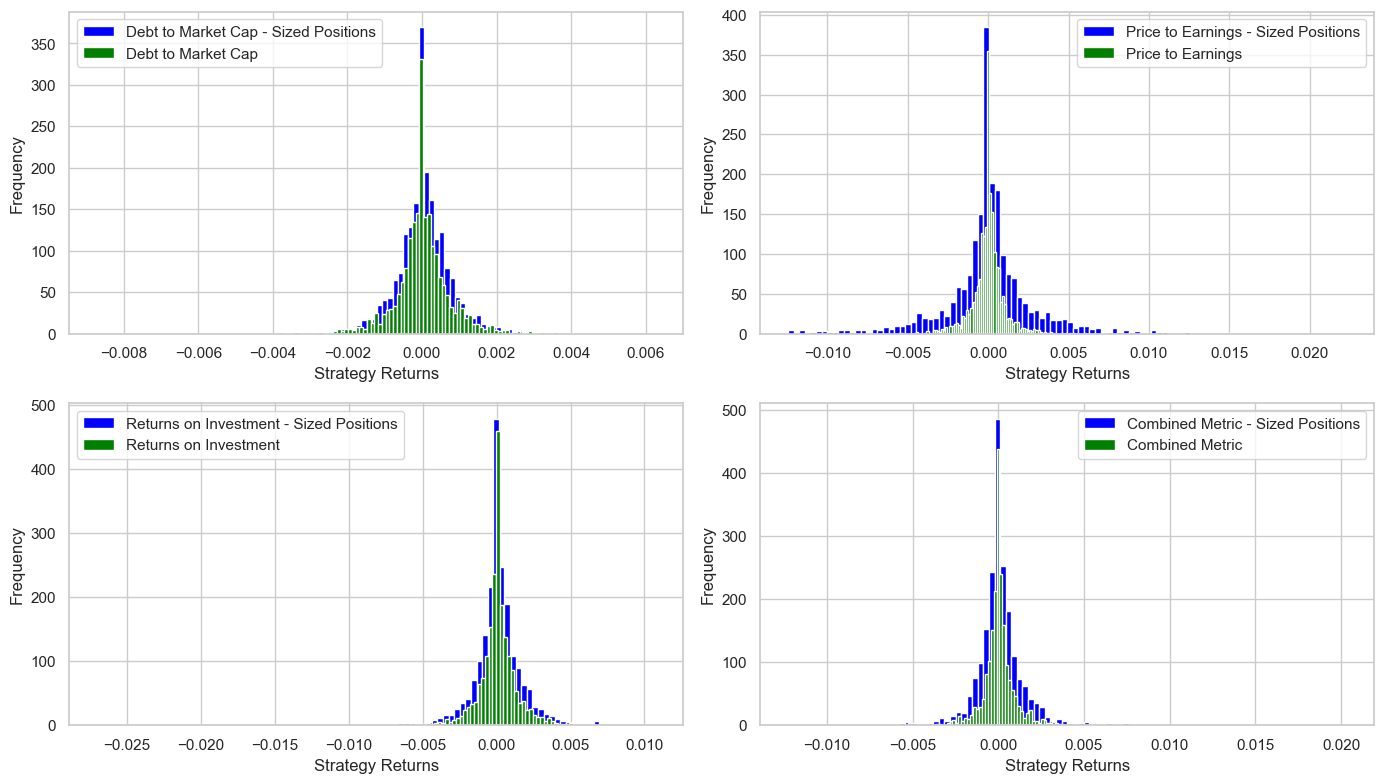

In [70]:
plt.figure(figsize=(14, 8))

plt.subplot(2, 2, 1)
plt.hist(debt_to_market_pnl_sized[['strategy_return']], bins=100, color='blue', label='Debt to Market Cap - Sized Positions')
plt.hist(debt_to_market_pnl[['strategy_return']], bins=100, color='green', label='Debt to Market Cap')
plt.xlabel('Strategy Returns')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(2, 2, 2)
plt.hist(price_to_earnings_pnl_sized[['strategy_return']], bins=100, color='blue', label='Price to Earnings - Sized Positions')
plt.hist(price_to_earnings_pnl[['strategy_return']], bins=100, color='green', label='Price to Earnings')
plt.xlabel('Strategy Returns')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(2, 2, 3)
plt.hist(returns_on_investment_pnl_sized[['strategy_return']], bins=100, color='blue', label='Returns on Investment - Sized Positions')
plt.hist(returns_on_investment_pnl[['strategy_return']], bins=100, color='green', label='Returns on Investment')
plt.xlabel('Strategy Returns')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(2, 2, 4)
plt.hist(combined_metric_pnl_sized[['strategy_return']], bins=100, color='blue', label='Combined Metric - Sized Positions')
plt.hist(combined_metric_pnl[['strategy_return']], bins=100, color='green', label='Combined Metric')
plt.xlabel('Strategy Returns')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

This last graph compares the distribution of the strategy returns for the different strategies. It illustrates what we identified before in terms of volatility, for example. The distributions are all centered around 0 with a small positive mean return. Sizing the position does change the distribution as we can see and as we observed in the performance summary dataframe earlier. By sizing our positions, we allow more volatility. Something we can see is also a higher kurtosis indicates more data in the tails and a sharper peak, while a lower kurtosis indicates a flatter peak and thinner tails. The distributions here appear to have a high kurtosis, especially the sized positions ones, as they have a very sharp peak and fat tails, indicating a concentration of returns around the mean and more extreme outcomes than a normal distribution would predict. The distributions for Debt to Market Cap and Price to Earnings appear to be somewhat positively skewed, with tails stretching towards the right. However, the "Returns on Investment" and "Combined Metric" distributions appear quite symmetrical, suggesting minimal skewness.

### 5. Conclusion

The data cleaning and pre-processing stage was critical in ensuring the reliability and accuracy of the subsequent analysis. The initial challenge was sourcing the financial data, which involved interfacing with the Quandl API and managing data downloads. Ensuring the data was clean necessitated the implementation of date checks and handling, alongside managing data integrity during the join operations across different financial tables. A significant preprocessing step was the alignment of financial reporting dates with trading dates, to prevent lookahead bias—a form of temporal error where future information is incorrectly used as if it were available at an earlier time. This step involved aligning the reporting 'filing_date' with the nearest trading day's 'close_price'. Additionally, calculating financial ratios required addressing missing and infinite values, as well as negative earnings, which were treated with a minimal positive value for the continuity of ratio calculations.

Coding the strategy involved the development of a class structure in Python to encapsulate the logic of quantile-based trading. The `QuantileTradingStrategy` class was at the heart of this logic, handling the computation of positions, adjusting these based on the re-balancing frequency, and calculating the strategy's PnL. It utilized quantiles to segment securities into buy and sell lists, where the top quantile was purchased, and the bottom quantile was sold short. The class was flexible, allowing sizing positions either equally or based on their quantile ranking. The `Rates` class complemented this by managing trading and borrowing costs, essential for realistic PnL computation.

Exploration of different strategies was extensive: varying the quantile thresholds allowed us to test the sensitivity of the strategy's performance to the degree of market segmentation. Using the change in ratios instead of absolute values aimed to capture momentum effects, hypothesizing that securities with increasing financial health metrics might continue to perform well. Combining ratios was a more nuanced approach, synthesizing multiple aspects of financial health into a single decision metric; this was further refined through weight optimization using Optuna, enhancing the strategy's return profile. Each strategy variant was evaluated not only on its raw returns but also through risk-adjusted metrics like the Sharpe ratio and tail risk measures such as skewness, kurtosis, and maximum drawdown, painting a comprehensive picture of the risk-return landscape. These efforts culminated in a stratified view of potential investment strategies, each with its nuanced risk and return profile, suitable for different investor preferences and market conditions.